In [1]:
# Installations spécifiques pour Kaggle
!pip install -q torchio
!pip install -q nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchio as tio
from torch.cuda.amp import GradScaler, autocast
import warnings
warnings.filterwarnings('ignore')

# Configuration optimisée pour la mémoire
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# Vérifier et configurer le GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name()}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [4]:
def load_data_paths(root_dir, has_seg=True):
    """Charger seulement les chemins des fichiers pour économiser la mémoire"""
    patients = [d for d in os.listdir(root_dir) 
                if os.path.isdir(os.path.join(root_dir, d)) and d.startswith("BraTS-SSA-")]
    data_list = []
    
    for patient_id in tqdm(patients):
        patient_path = os.path.join(root_dir, patient_id)
        
        # Stocker seulement les chemins
        file_paths = {
            "id": patient_id,
            "flair_path": os.path.join(patient_path, f"{patient_id}-t2f.nii"),
            "t1_path": os.path.join(patient_path, f"{patient_id}-t1n.nii"),
            "t1ce_path": os.path.join(patient_path, f"{patient_id}-t1c.nii"),
            "t2_path": os.path.join(patient_path, f"{patient_id}-t2w.nii"),
        }
        
        if has_seg:
            seg_path = os.path.join(patient_path, f"{patient_id}-seg.nii")
            file_paths["seg_path"] = seg_path if os.path.exists(seg_path) else None
        
        # Vérifier que tous les fichiers existent
        required_files = [file_paths["flair_path"], file_paths["t1_path"], 
                         file_paths["t1ce_path"], file_paths["t2_path"]]
        if all(os.path.exists(f) for f in required_files):
            data_list.append(file_paths)
        else:
            print(f"Fichiers manquants pour {patient_id}")
    
    return pd.DataFrame(data_list)

# Charger les chemins des données
root_dir_2023 = "/kaggle/input/brats2025/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2"
data_2023 = load_data_paths(root_dir_2023, has_seg=True)
print(f'BraTS 2023: {len(data_2023)} patients')

root_dir_2024 = "/kaggle/input/brats2025/BraTS2024-SSA-Challenge-ValidationData/BraTS2024-SSA-Challenge-ValidationData"
data_2024 = load_data_paths(root_dir_2024, has_seg=False)
print(f'BraTS 2024: {len(data_2024)} patients')

100%|██████████| 60/60 [00:00<00:00, 411.01it/s]


BraTS 2023: 60 patients


100%|██████████| 35/35 [00:00<00:00, 405.53it/s]

BraTS 2024: 35 patients


In [5]:
class BratsDatasetOptimized(Dataset):
    def __init__(self, dataframe, crop_size=(128, 128, 128), has_seg=True):
        self.dataframe = dataframe
        self.crop_size = crop_size
        self.has_seg = has_seg

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        patient = self.dataframe.iloc[idx]
        
        # Charger les images à la demande
        flair = nib.load(patient["flair_path"]).get_fdata()
        t1 = nib.load(patient["t1_path"]).get_fdata()
        t1ce = nib.load(patient["t1ce_path"]).get_fdata()
        t2 = nib.load(patient["t2_path"]).get_fdata()
        
        # Normalisation
        flair = self.normalize(flair)
        t1 = self.normalize(t1)
        t1ce = self.normalize(t1ce)
        t2 = self.normalize(t2)
        
        # Stack et crop
        image = np.stack([flair, t1, t1ce, t2], axis=0)
        image = self.center_crop_or_pad(image, self.crop_size)
        
        if self.has_seg and patient.get("seg_path") and os.path.exists(patient["seg_path"]):
            seg = nib.load(patient["seg_path"]).get_fdata()
            seg = np.clip(seg.astype(np.uint8), 0, 3)
            seg = self.center_crop_or_pad(seg[None, ...], self.crop_size).squeeze(0)
            return torch.tensor(image).float(), torch.tensor(seg).long()
        else:
            return torch.tensor(image).float()

    def normalize(self, data):
        data = data.astype(np.float32)
        # Normalisation robuste
        p1, p99 = np.percentile(data[data > 0], [1, 99])
        data = np.clip(data, p1, p99)
        mask = data > 0
        if np.any(mask):
            data[mask] = (data[mask] - data[mask].mean()) / (data[mask].std() + 1e-8)
        return data
    
    def center_crop_or_pad(self, data, target_size):
        """Crop ou pad au centre pour atteindre la taille cible"""
        if len(data.shape) == 4:  # image avec channels
            current_size = data.shape[1:]
        else:  # segmentation
            current_size = data.shape
            
        # Calculer les indices de crop/pad
        crops_pads = []
        for current, target in zip(current_size, target_size):
            if current >= target:
                # Crop
                start = (current - target) // 2
                end = start + target
                crops_pads.append((start, end))
            else:
                # Pad
                pad_total = target - current
                pad_before = pad_total // 2
                pad_after = pad_total - pad_before
                crops_pads.append((pad_before, pad_after))
        
        # Appliquer crop/pad
        if len(data.shape) == 4:  # image
            result = data[:, 
                         crops_pads[0][0]:crops_pads[0][1] if current_size[0] >= target_size[0] else None,
                         crops_pads[1][0]:crops_pads[1][1] if current_size[1] >= target_size[1] else None,
                         crops_pads[2][0]:crops_pads[2][1] if current_size[2] >= target_size[2] else None]
            
            # Padding si nécessaire
            pad_widths = [(0, 0)]  # pas de padding pour les channels
            for i, (current, target) in enumerate(zip(current_size, target_size)):
                if current < target:
                    pad_before, pad_after = crops_pads[i]
                    pad_widths.append((pad_before, pad_after))
                else:
                    pad_widths.append((0, 0))
            
            if any(p[0] > 0 or p[1] > 0 for p in pad_widths[1:]):
                result = np.pad(result, pad_widths, mode='constant', constant_values=0)
        else:  # segmentation
            result = data[crops_pads[0][0]:crops_pads[0][1] if current_size[0] >= target_size[0] else None,
                         crops_pads[1][0]:crops_pads[1][1] if current_size[1] >= target_size[1] else None,
                         crops_pads[2][0]:crops_pads[2][1] if current_size[2] >= target_size[2] else None]
            
            # Padding si nécessaire
            pad_widths = []
            for i, (current, target) in enumerate(zip(current_size, target_size)):
                if current < target:
                    pad_before, pad_after = crops_pads[i]
                    pad_widths.append((pad_before, pad_after))
                else:
                    pad_widths.append((0, 0))
            
            if any(p[0] > 0 or p[1] > 0 for p in pad_widths):
                result = np.pad(result, pad_widths, mode='constant', constant_values=0)
        
        return result


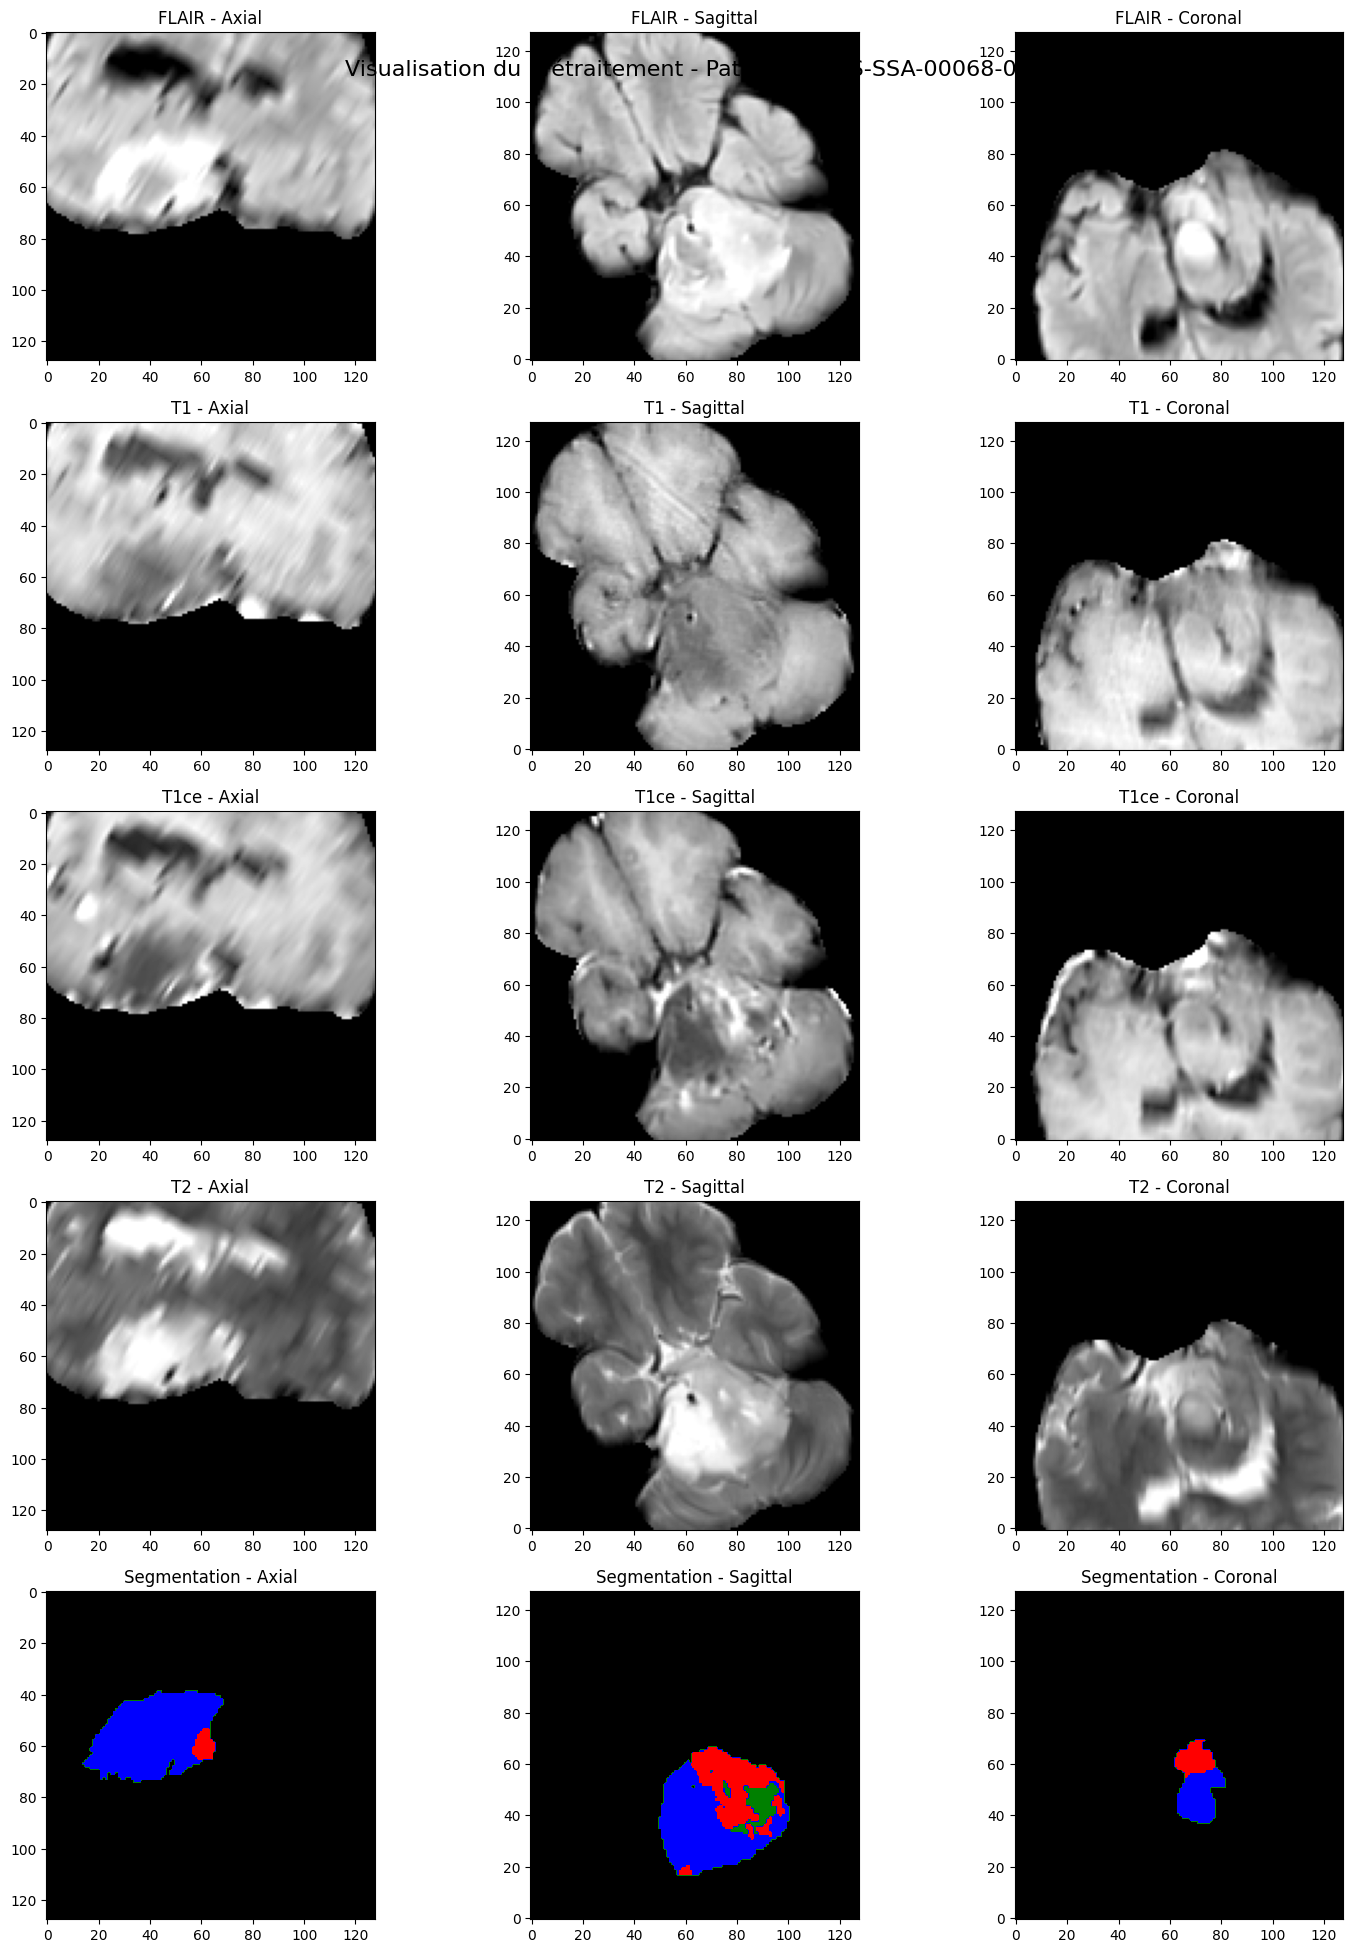

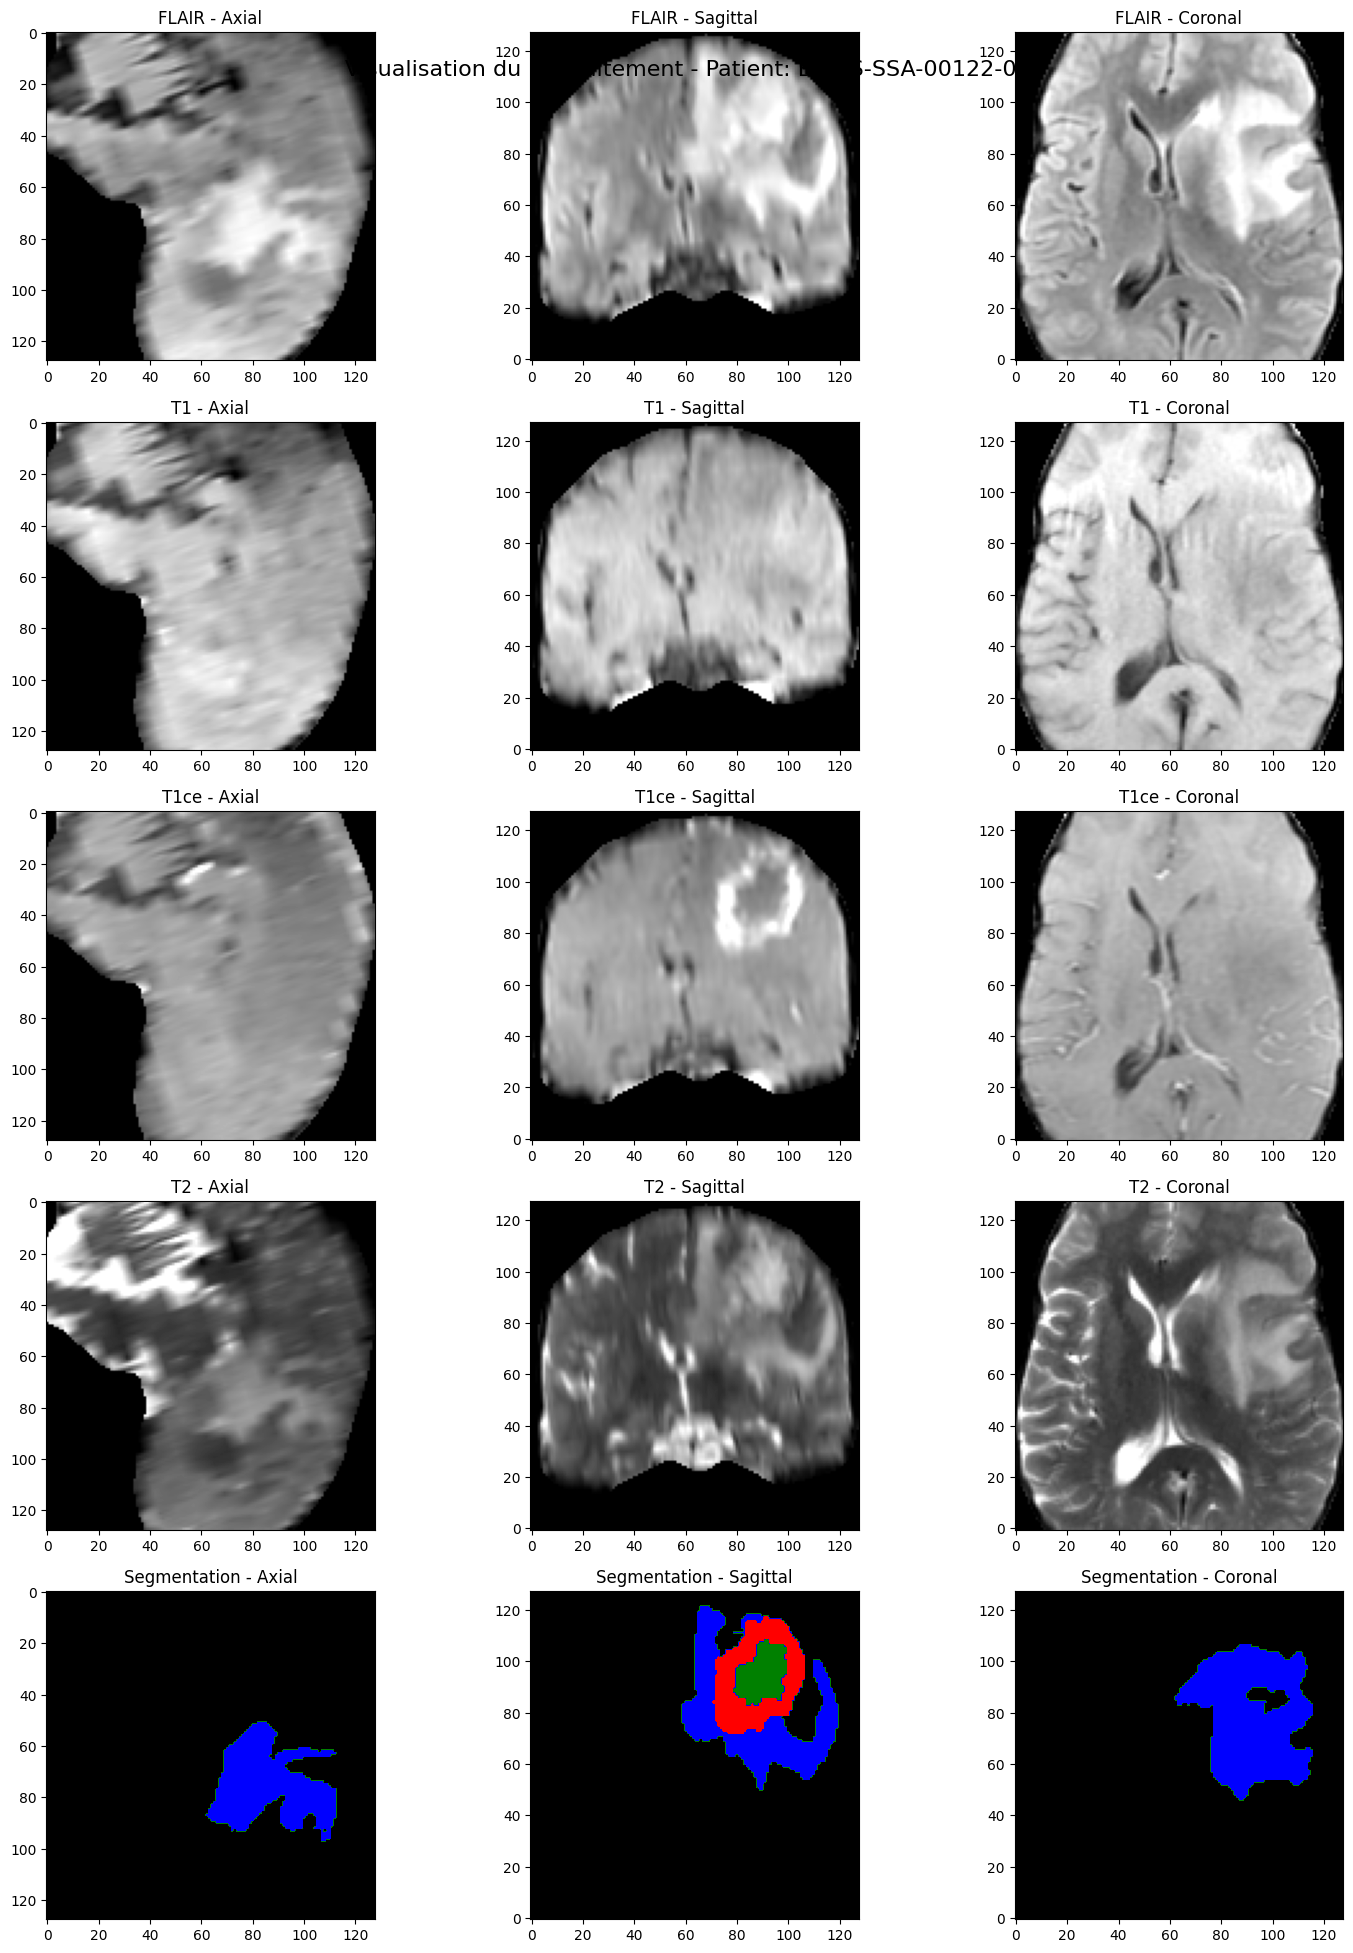

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def visualize_sample(dataset, idx=0):
    """Visualise un échantillon du dataset"""
    sample = dataset[idx]
    patient_id = dataset.dataframe.iloc[idx]["id"]
    
    if dataset.has_seg:
        image, seg = sample
    else:
        image = sample
        seg = None
    
    # Convertir en numpy et réorganiser les dimensions
    image = image.numpy()
    if seg is not None:
        seg = seg.numpy()
    
    # Modalités disponibles
    modalities = ['FLAIR', 'T1', 'T1ce', 'T2']
    
    # Créer la figure
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    plt.suptitle(f"Visualisation du prétraitement - Patient: {patient_id}", fontsize=16, y=0.95)
    
    # Paramètres d'affichage
    slice_idx = 64  # Milieu du volume
    cmap = 'gray'
    seg_cmap = mcolors.ListedColormap(['black', 'green', 'blue', 'red'])
    
    # Afficher chaque modalité
    for i, mod in enumerate(modalities):
        # Coupe axiale (Z)
        axes[i, 0].imshow(image[i, slice_idx, :, :], cmap=cmap)
        axes[i, 0].set_title(f"{mod} - Axial")
        
        # Coupe sagittale (Y)
        axes[i, 1].imshow(image[i, :, slice_idx, :].T, cmap=cmap, origin='lower')
        axes[i, 1].set_title(f"{mod} - Sagittal")
        
        # Coupe coronale (X)
        axes[i, 2].imshow(image[i, :, :, slice_idx].T, cmap=cmap, origin='lower')
        axes[i, 2].set_title(f"{mod} - Coronal")
    
    # Afficher la segmentation si disponible
    if seg is not None:
        # Coupe axiale (Z)
        axes[4, 0].imshow(seg[slice_idx, :, :], cmap=seg_cmap, vmin=0, vmax=3)
        axes[4, 0].set_title("Segmentation - Axial")
        
        # Coupe sagittale (Y)
        axes[4, 1].imshow(seg[:, slice_idx, :].T, cmap=seg_cmap, 
                          vmin=0, vmax=3, origin='lower')
        axes[4, 1].set_title("Segmentation - Sagittal")
        
        # Coupe coronale (X)
        axes[4, 2].imshow(seg[:, :, slice_idx].T, cmap=seg_cmap, 
                          vmin=0, vmax=3, origin='lower')
        axes[4, 2].set_title("Segmentation - Coronal")
    else:
        fig.delaxes(axes[4, 0])
        fig.delaxes(axes[4, 1])
        fig.delaxes(axes[4, 2])
    
    plt.tight_layout()
    plt.show()

# Créer le dataset avec un crop plus petit pour la visualisation
visualization_dataset = BratsDatasetOptimized(
    dataframe=data_2023,
    crop_size=(128, 128, 128),
    has_seg=True
)

# Visualiser le premier patient
visualize_sample(visualization_dataset, idx=0)

# Visualiser un patient aléatoire
import random
random_idx = random.randint(0, len(visualization_dataset) - 1)
visualize_sample(visualization_dataset, idx=random_idx)

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Calculer le padding pour matcher les dimensions
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet3DOptimized(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, base_channels=32, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        factor = 2 if bilinear else 1

        self.inc = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 16 // factor)
        
        self.up1 = Up(base_channels * 16, base_channels * 8 // factor, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 4 // factor, bilinear)
        self.up3 = Up(base_channels * 4, base_channels * 2 // factor, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, bilinear)
        
        self.outc = nn.Conv3d(base_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        del x5, x4  # Libérer la mémoire
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        
        logits = self.outc(x)
        return logits


In [8]:
from torchinfo import summary
model = UNet3DOptimized()
summary(model, input_size=(1, 4, 64, 64, 64))  # (batch_size, channels, D, H, W)


Layer (type:depth-idx)                        Output Shape              Param #
UNet3DOptimized                               [1, 4, 64, 64, 64]        --
├─DoubleConv: 1-1                             [1, 32, 64, 64, 64]       --
│    └─Sequential: 2-1                        [1, 32, 64, 64, 64]       --
│    │    └─Conv3d: 3-1                       [1, 32, 64, 64, 64]       3,456
│    │    └─BatchNorm3d: 3-2                  [1, 32, 64, 64, 64]       64
│    │    └─ReLU: 3-3                         [1, 32, 64, 64, 64]       --
│    │    └─Conv3d: 3-4                       [1, 32, 64, 64, 64]       27,648
│    │    └─BatchNorm3d: 3-5                  [1, 32, 64, 64, 64]       64
│    │    └─ReLU: 3-6                         [1, 32, 64, 64, 64]       --
├─Down: 1-2                                   [1, 64, 32, 32, 32]       --
│    └─Sequential: 2-2                        [1, 64, 32, 32, 32]       --
│    │    └─MaxPool3d: 3-7                    [1, 32, 32, 32, 32]       --
│    │    └─D

In [10]:
# Configuration pour économiser la mémoire
CROP_SIZE = (96, 96, 96)  # Taille réduite
BATCH_SIZE = 1  # Batch size de 1 pour économiser la mémoire
NUM_WORKERS = 2

# Diviser les données d'entraînement
train_df, val_df = train_test_split(data_2023, test_size=0.2, random_state=42)

# Créer les datasets
train_dataset = BratsDatasetOptimized(train_df, crop_size=CROP_SIZE, has_seg=True)
val_dataset = BratsDatasetOptimized(val_df, crop_size=CROP_SIZE, has_seg=True)
test_dataset = BratsDatasetOptimized(data_2024, crop_size=CROP_SIZE, has_seg=False)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 48
Validation samples: 12
Test samples: 35


In [11]:
# Créer le modèle avec moins de paramètres
model = UNet3DOptimized(in_channels=4, out_channels=4, base_channels=16, bilinear=True).to(device)

# Optimiseur et scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Loss function avec poids pour gérer le déséquilibre des classes
class_weights = torch.tensor([1.0, 2.0, 3.0, 3.0]).to(device)  # Poids ajustés pour BraTS
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Scaler pour mixed precision
scaler = GradScaler()

# Fonction Dice Score
def dice_score(pred, target, num_classes=4, smooth=1e-6):
    pred = F.one_hot(pred, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
    target = F.one_hot(target, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
    
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()

In [12]:
def train_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    num_batches = len(loader)
    
    pbar = tqdm(loader, desc="Training")
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Backward pass avec gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Calcul des métriques
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            dice = dice_score(preds, masks)
        
        running_loss += loss.item()
        running_dice += dice.item()
        
        # Mise à jour de la progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Dice': f'{dice.item():.4f}'
        })
        
        # Nettoyage mémoire
        del images, masks, outputs, loss
        torch.cuda.empty_cache()
    
    return running_loss / num_batches, running_dice / num_batches

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    num_batches = len(loader)
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, masks in pbar:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            preds = torch.argmax(outputs, dim=1)
            dice = dice_score(preds, masks)
            
            running_loss += loss.item()
            running_dice += dice.item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}'
            })
            
            # Nettoyage mémoire
            del images, masks, outputs
            torch.cuda.empty_cache()
    
    return running_loss / num_batches, running_dice / num_batches

In [13]:
num_epochs = 30
best_val_dice = 0.0
history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}

print(f"Démarrage de l'entraînement sur {num_epochs} époques...")
print(f"Taille des images: {CROP_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Entraînement
    train_loss, train_dice = train_epoch(model, train_loader, optimizer, criterion, device, scaler)
    print(f"Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
    
    # Validation
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    print(f"Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")
    
    # Mettre à jour l'historique
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    
    # Scheduler step
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.2e}")
    
    # Sauvegarder le meilleur modèle
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'history': history,
            'crop_size': CROP_SIZE
        }, '/kaggle/working/best_model_optimized.pth')
        print(f"✓ Nouveau meilleur modèle sauvegardé ! (Dice: {val_dice:.4f})")
    
    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()

print(f"\nEntraînement terminé ! Meilleur Dice Score: {best_val_dice:.4f}")

Démarrage de l'entraînement sur 30 époques...
Taille des images: (96, 96, 96)
Batch size: 1

Epoch 1/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [01:23<00:00,  1.75s/it, Loss=0.9592, Dice=0.3937]


Train - Loss: 0.9434, Dice: 0.3707


Validation: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it, Loss=0.7777, Dice=0.3779]


Val   - Loss: 0.8483, Dice: 0.3853
Learning Rate: 9.94e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.3853)

Epoch 2/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:51<00:00,  1.07s/it, Loss=0.5833, Dice=0.6593]


Train - Loss: 0.6800, Dice: 0.4778


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.8544, Dice=0.2770]


Val   - Loss: 0.6813, Dice: 0.4710
Learning Rate: 9.76e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.4710)

Epoch 3/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:51<00:00,  1.07s/it, Loss=0.4154, Dice=0.3993]


Train - Loss: 0.5453, Dice: 0.5396


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=1.1551, Dice=0.2107]


Val   - Loss: 0.8327, Dice: 0.3622
Learning Rate: 9.46e-04

Epoch 4/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:51<00:00,  1.07s/it, Loss=0.4760, Dice=0.6159]


Train - Loss: 0.4558, Dice: 0.5597


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=1.3870, Dice=0.1907]


Val   - Loss: 0.9326, Dice: 0.3267
Learning Rate: 9.05e-04

Epoch 5/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.6759, Dice=0.4684]


Train - Loss: 0.4219, Dice: 0.5700


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.4996, Dice=0.3699]


Val   - Loss: 0.3730, Dice: 0.4943
Learning Rate: 8.54e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.4943)

Epoch 6/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.2597, Dice=0.5732]


Train - Loss: 0.3652, Dice: 0.6217


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=1.2725, Dice=0.2051]


Val   - Loss: 0.6414, Dice: 0.4086
Learning Rate: 7.94e-04

Epoch 7/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:51<00:00,  1.06s/it, Loss=0.2616, Dice=0.8636]


Train - Loss: 0.3294, Dice: 0.6280


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.6656, Dice=0.3529]


Val   - Loss: 0.4348, Dice: 0.5041
Learning Rate: 7.27e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5041)

Epoch 8/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.3203, Dice=0.6308]


Train - Loss: 0.3056, Dice: 0.6424


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.6054, Dice=0.3530]


Val   - Loss: 0.3841, Dice: 0.4976
Learning Rate: 6.55e-04

Epoch 9/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.2855, Dice=0.6884]


Train - Loss: 0.3019, Dice: 0.6458


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it, Loss=0.7510, Dice=0.3205]


Val   - Loss: 0.4326, Dice: 0.5060
Learning Rate: 5.79e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5060)

Epoch 10/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.7494, Dice=0.5325]


Train - Loss: 0.2812, Dice: 0.6611


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it, Loss=0.8495, Dice=0.2814]


Val   - Loss: 0.4598, Dice: 0.4910
Learning Rate: 5.01e-04

Epoch 11/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.1931, Dice=0.5774]


Train - Loss: 0.2610, Dice: 0.6799


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.6453, Dice=0.3312]


Val   - Loss: 0.3619, Dice: 0.5194
Learning Rate: 4.22e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5194)

Epoch 12/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:51<00:00,  1.07s/it, Loss=0.1056, Dice=0.7068]


Train - Loss: 0.2524, Dice: 0.6874


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.4256, Dice=0.3636]


Val   - Loss: 0.3104, Dice: 0.5350
Learning Rate: 3.46e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5350)

Epoch 13/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.2480, Dice=0.6563]


Train - Loss: 0.2364, Dice: 0.6882


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.6420, Dice=0.3536]


Val   - Loss: 0.3414, Dice: 0.5486
Learning Rate: 2.74e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5486)

Epoch 14/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.2620, Dice=0.6414]


Train - Loss: 0.2280, Dice: 0.7065


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it, Loss=0.7602, Dice=0.3260]


Val   - Loss: 0.3977, Dice: 0.5330
Learning Rate: 2.07e-04

Epoch 15/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.1855, Dice=0.8368]


Train - Loss: 0.2219, Dice: 0.7141


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.4407, Dice=0.4483]


Val   - Loss: 0.3071, Dice: 0.5595
Learning Rate: 1.47e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5595)

Epoch 16/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:51<00:00,  1.07s/it, Loss=0.3359, Dice=0.7803]


Train - Loss: 0.2141, Dice: 0.7230


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it, Loss=0.4077, Dice=0.3931]


Val   - Loss: 0.3127, Dice: 0.5677
Learning Rate: 9.64e-05
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5677)

Epoch 17/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.2419, Dice=0.9185]


Train - Loss: 0.2123, Dice: 0.7102


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.6232, Dice=0.3968]


Val   - Loss: 0.3465, Dice: 0.5487
Learning Rate: 5.54e-05

Epoch 18/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.0995, Dice=0.6866]


Train - Loss: 0.2074, Dice: 0.7226


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it, Loss=0.5403, Dice=0.4213]


Val   - Loss: 0.3289, Dice: 0.5552
Learning Rate: 2.54e-05

Epoch 19/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.2023, Dice=0.6450]


Train - Loss: 0.2047, Dice: 0.7248


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it, Loss=0.6135, Dice=0.4014]


Val   - Loss: 0.3506, Dice: 0.5473
Learning Rate: 7.15e-06

Epoch 20/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.1198, Dice=0.6655]


Train - Loss: 0.2035, Dice: 0.7268


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it, Loss=0.4334, Dice=0.4620]


Val   - Loss: 0.3102, Dice: 0.5677
Learning Rate: 1.00e-06
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5677)

Epoch 21/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.04s/it, Loss=0.0955, Dice=0.6930]


Train - Loss: 0.2031, Dice: 0.7272


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it, Loss=0.5401, Dice=0.4116]


Val   - Loss: 0.3275, Dice: 0.5494
Learning Rate: 7.15e-06

Epoch 22/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.1088, Dice=0.6091]


Train - Loss: 0.2033, Dice: 0.7270


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it, Loss=0.6380, Dice=0.3773]


Val   - Loss: 0.3404, Dice: 0.5501
Learning Rate: 2.54e-05

Epoch 23/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.04s/it, Loss=0.1090, Dice=0.6090]


Train - Loss: 0.2040, Dice: 0.7259


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it, Loss=0.4306, Dice=0.4417]


Val   - Loss: 0.3010, Dice: 0.5599
Learning Rate: 5.54e-05

Epoch 24/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:49<00:00,  1.04s/it, Loss=0.2019, Dice=0.6439]


Train - Loss: 0.2042, Dice: 0.7247


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.08s/it, Loss=0.6326, Dice=0.3786]


Val   - Loss: 0.3424, Dice: 0.5466
Learning Rate: 9.64e-05

Epoch 25/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:52<00:00,  1.10s/it, Loss=0.1949, Dice=0.8745]


Train - Loss: 0.2043, Dice: 0.7248


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it, Loss=0.3171, Dice=0.5135]


Val   - Loss: 0.2901, Dice: 0.5713
Learning Rate: 1.47e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5713)

Epoch 26/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.04s/it, Loss=0.1262, Dice=0.6944]


Train - Loss: 0.2059, Dice: 0.7261


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.07s/it, Loss=0.4015, Dice=0.4488]


Val   - Loss: 0.3044, Dice: 0.5788
Learning Rate: 2.07e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5788)

Epoch 27/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.1946, Dice=0.7967]


Train - Loss: 0.2082, Dice: 0.7129


Validation: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it, Loss=0.6071, Dice=0.3968]


Val   - Loss: 0.3457, Dice: 0.5600
Learning Rate: 2.74e-04

Epoch 28/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.7228, Dice=0.5567]


Train - Loss: 0.2081, Dice: 0.7278


Validation: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it, Loss=0.4118, Dice=0.4433]


Val   - Loss: 0.3016, Dice: 0.5744
Learning Rate: 3.46e-04

Epoch 29/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it, Loss=0.3050, Dice=0.8973]


Train - Loss: 0.2098, Dice: 0.7170


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.08s/it, Loss=0.8728, Dice=0.3024]


Val   - Loss: 0.4020, Dice: 0.5379
Learning Rate: 4.22e-04

Epoch 30/30
--------------------------------------------------


Training: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it, Loss=0.1901, Dice=0.5137]


Train - Loss: 0.2108, Dice: 0.7166


Validation: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it, Loss=0.3260, Dice=0.4987]


Val   - Loss: 0.2735, Dice: 0.5891
Learning Rate: 5.00e-04
✓ Nouveau meilleur modèle sauvegardé ! (Dice: 0.5891)

Entraînement terminé ! Meilleur Dice Score: 0.5891


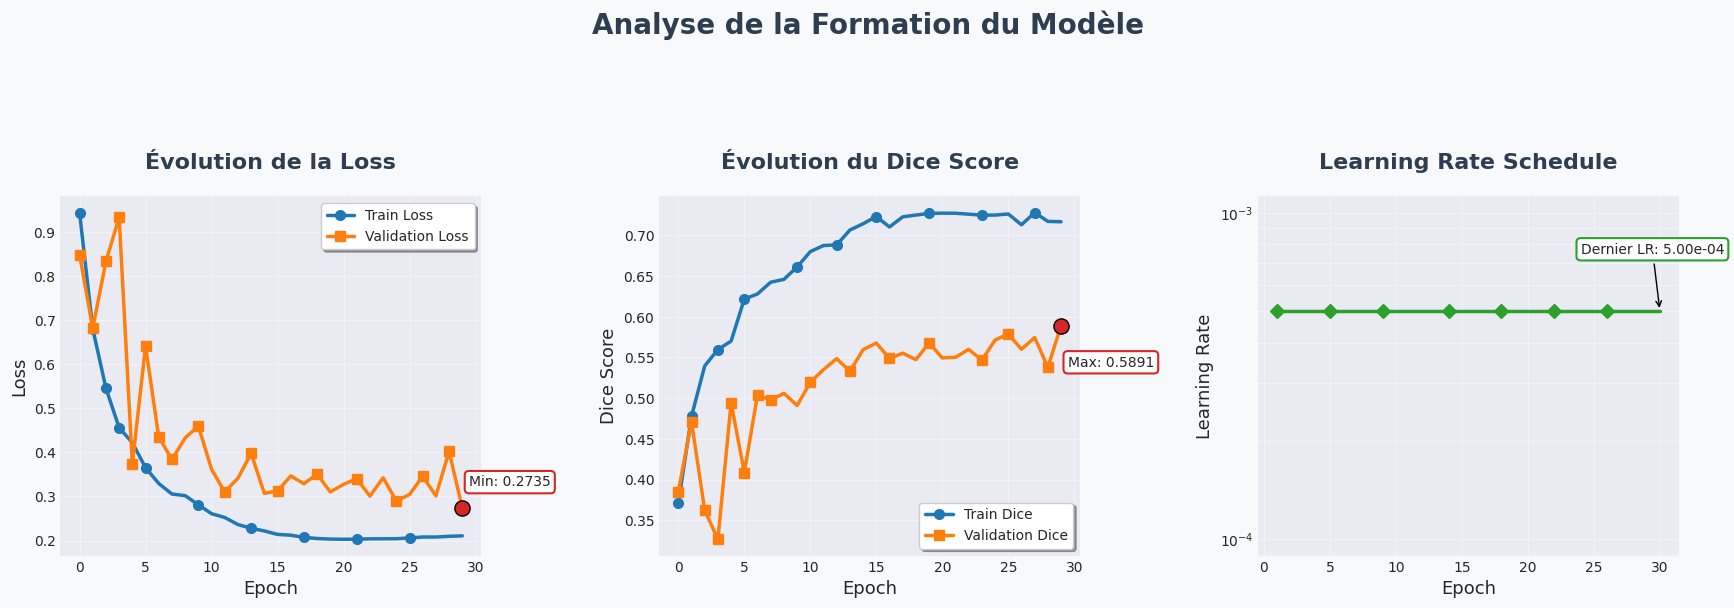

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlepad'] = 20

# Création de la figure
fig = plt.figure(figsize=(18, 6), dpi=100)
fig.patch.set_facecolor('#f8f9fa')

# Palette de couleurs
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Subplot 1: Loss
ax1 = plt.subplot(1, 3, 1)
ax1.plot(history['train_loss'], 
         label='Train Loss', 
         color=colors[0], 
         lw=2.5, 
         marker='o',
         markersize=7,
         markevery=0.1)
ax1.plot(history['val_loss'], 
         label='Validation Loss', 
         color=colors[1], 
         lw=2.5, 
         marker='s',
         markersize=7,
         markevery=0.1)

# Ajout du point optimal
min_epoch = np.argmin(history['val_loss'])
ax1.scatter(min_epoch, history['val_loss'][min_epoch], 
            s=120, 
            zorder=10,
            color='#d62728',
            edgecolor='black')
ax1.annotate(f'Min: {history["val_loss"][min_epoch]:.4f}',
            xy=(min_epoch, history["val_loss"][min_epoch]),
            xytext=(min_epoch+0.5, history["val_loss"][min_epoch]+0.05),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#d62728', lw=1.5))

# Configuration de l'axe
ax1.set_title('Évolution de la Loss', fontsize=16, fontweight='bold', color='#2c3e50')
ax1.set_xlabel('Epoch', fontsize=13)
ax1.set_ylabel('Loss', fontsize=13)
ax1.legend(frameon=True, shadow=True, facecolor='white')
ax1.grid(which='both', alpha=0.4)
ax1.set_axisbelow(True)

# Subplot 2: Dice Score
ax2 = plt.subplot(1, 3, 2)
ax2.plot(history['train_dice'], 
         label='Train Dice', 
         color=colors[0], 
         lw=2.5, 
         marker='o',
         markersize=7,
         markevery=0.1)
ax2.plot(history['val_dice'], 
         label='Validation Dice', 
         color=colors[1], 
         lw=2.5, 
         marker='s',
         markersize=7,
         markevery=0.1)

# Ajout du point optimal
max_epoch = np.argmax(history['val_dice'])
ax2.scatter(max_epoch, history['val_dice'][max_epoch], 
            s=120, 
            zorder=10,
            color='#d62728',
            edgecolor='black')
ax2.annotate(f'Max: {history["val_dice"][max_epoch]:.4f}',
            xy=(max_epoch, history["val_dice"][max_epoch]),
            xytext=(max_epoch+0.5, history["val_dice"][max_epoch]-0.05),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#d62728', lw=1.5))

# Configuration de l'axe
ax2.set_title('Évolution du Dice Score', fontsize=16, fontweight='bold', color='#2c3e50')
ax2.set_xlabel('Epoch', fontsize=13)
ax2.set_ylabel('Dice Score', fontsize=13)
ax2.legend(frameon=True, shadow=True, facecolor='white')
ax2.grid(which='both', alpha=0.4)
ax2.set_axisbelow(True)

# Subplot 3: Learning Rate
ax3 = plt.subplot(1, 3, 3)
epochs = range(1, len(history['train_loss']) + 1)
ax3.plot(epochs, 
         [scheduler.get_last_lr()[0] for _ in epochs], 
         color=colors[2], 
         lw=2.5, 
         marker='D',
         markersize=7,
         markevery=0.1)

# Configuration de l'axe
ax3.set_title('Learning Rate Schedule', fontsize=16, fontweight='bold', color='#2c3e50')
ax3.set_xlabel('Epoch', fontsize=13)
ax3.set_ylabel('Learning Rate', fontsize=13)
ax3.set_yscale('log')
ax3.grid(which='both', alpha=0.4)
ax3.set_axisbelow(True)

# Ajout d'annotation pour le dernier LR
last_lr = scheduler.get_last_lr()[0]
ax3.annotate(f'Dernier LR: {last_lr:.2e}',
            xy=(epochs[-1], last_lr),
            xytext=(epochs[-1]-len(epochs)*0.2, last_lr*1.5),
            fontsize=10,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=colors[2], lw=1.5))

# Ajustements finaux
plt.suptitle('Analyse de la Formation du Modèle', 
             fontsize=20, 
             fontweight='bold', 
             color='#2c3e50',
             y=1.05)
plt.tight_layout(pad=3.0)
fig.savefig('/kaggle/working/training_curves_optimized.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor())
plt.show()

In [15]:
def predict_test_data(model, test_loader, device, crop_size):
    model.eval()
    predictions = {}
    
    print("Génération des prédictions sur les données de test...")
    with torch.no_grad():
        for idx, data in enumerate(tqdm(test_loader)):
            images = data.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
            
            # Récupérer l'ID du patient
            patient_id = test_dataset.dataframe.iloc[idx]["id"]
            
            # Convertir en numpy et sauvegarder
            pred_np = preds.cpu().numpy().squeeze(0).astype(np.uint8)
            predictions[patient_id] = pred_np
            
            # Nettoyage mémoire
            del images, outputs, probs, preds
            torch.cuda.empty_cache()
    
    return predictions

# Charger le meilleur modèle
print("Chargement du meilleur modèle...")
checkpoint = torch.load('/kaggle/working/best_model_optimized.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Modèle chargé (Dice: {checkpoint['val_dice']:.4f})")

# Générer les prédictions
test_predictions = predict_test_data(model, test_loader, device, CROP_SIZE)

Chargement du meilleur modèle...
Modèle chargé (Dice: 0.5891)
Génération des prédictions sur les données de test...


100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


In [16]:
# Créer le dossier de sortie
output_dir = "/kaggle/working/predictions_optimized"
os.makedirs(output_dir, exist_ok=True)

print("Sauvegarde des prédictions...")
for patient_id, pred in tqdm(test_predictions.items()):
    # Créer l'image NIfTI avec une matrice d'affine standard
    affine = np.eye(4)
    pred_img = nib.Nifti1Image(pred, affine)
    
    # Sauvegarder le fichier
    output_path = os.path.join(output_dir, f"{patient_id}-seg.nii")
    nib.save(pred_img, output_path)

print(f"✓ {len(test_predictions)} prédictions sauvegardées dans {output_dir}")

# Créer l'archive pour la soumission
print("Création de l'archive de soumission...")
!cd /kaggle/working/predictions_optimized && zip -r /kaggle/working/submission_optimized.zip *.nii

print("✓ Archive 'submission_optimized.zip' créée et prête pour la soumission !")

Sauvegarde des prédictions...


100%|██████████| 35/35 [00:00<00:00, 100.81it/s]


✓ 35 prédictions sauvegardées dans /kaggle/working/predictions_optimized
Création de l'archive de soumission...
updating: BraTS-SSA-00125-000-seg.nii (deflated 98%)
updating: BraTS-SSA-00126-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00129-000-seg.nii (deflated 97%)
updating: BraTS-SSA-00130-000-seg.nii (deflated 98%)
updating: BraTS-SSA-00132-000-seg.nii (deflated 97%)
updating: BraTS-SSA-00134-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00136-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00137-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00138-000-seg.nii (deflated 98%)
updating: BraTS-SSA-00139-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00140-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00143-000-seg.nii (deflated 97%)
updating: BraTS-SSA-00148-000-seg.nii (deflated 98%)
updating: BraTS-SSA-00154-000-seg.nii (deflated 98%)
updating: BraTS-SSA-00155-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00157-000-seg.nii (deflated 99%)
updating: BraTS-SSA-00158-000-seg.nii (d

Visualisation des prédictions pour quelques cas de test...


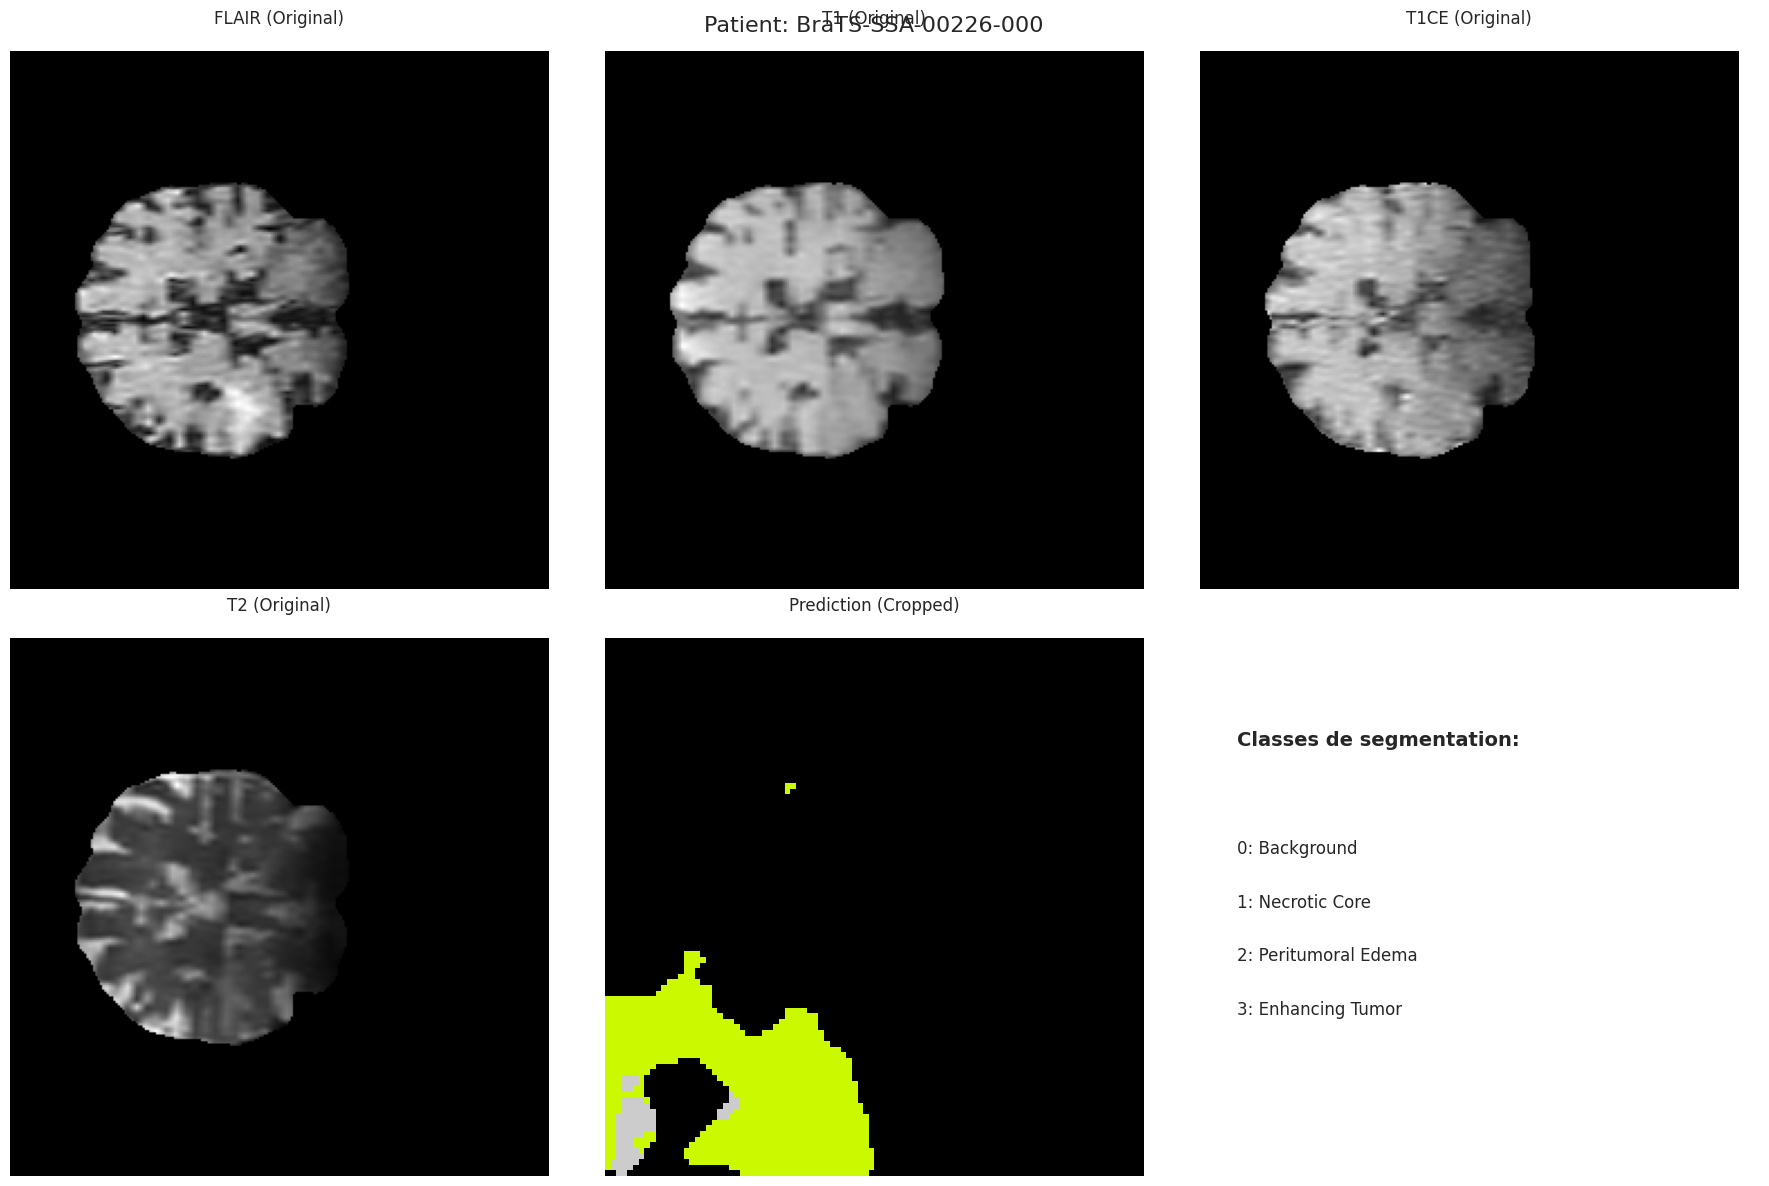

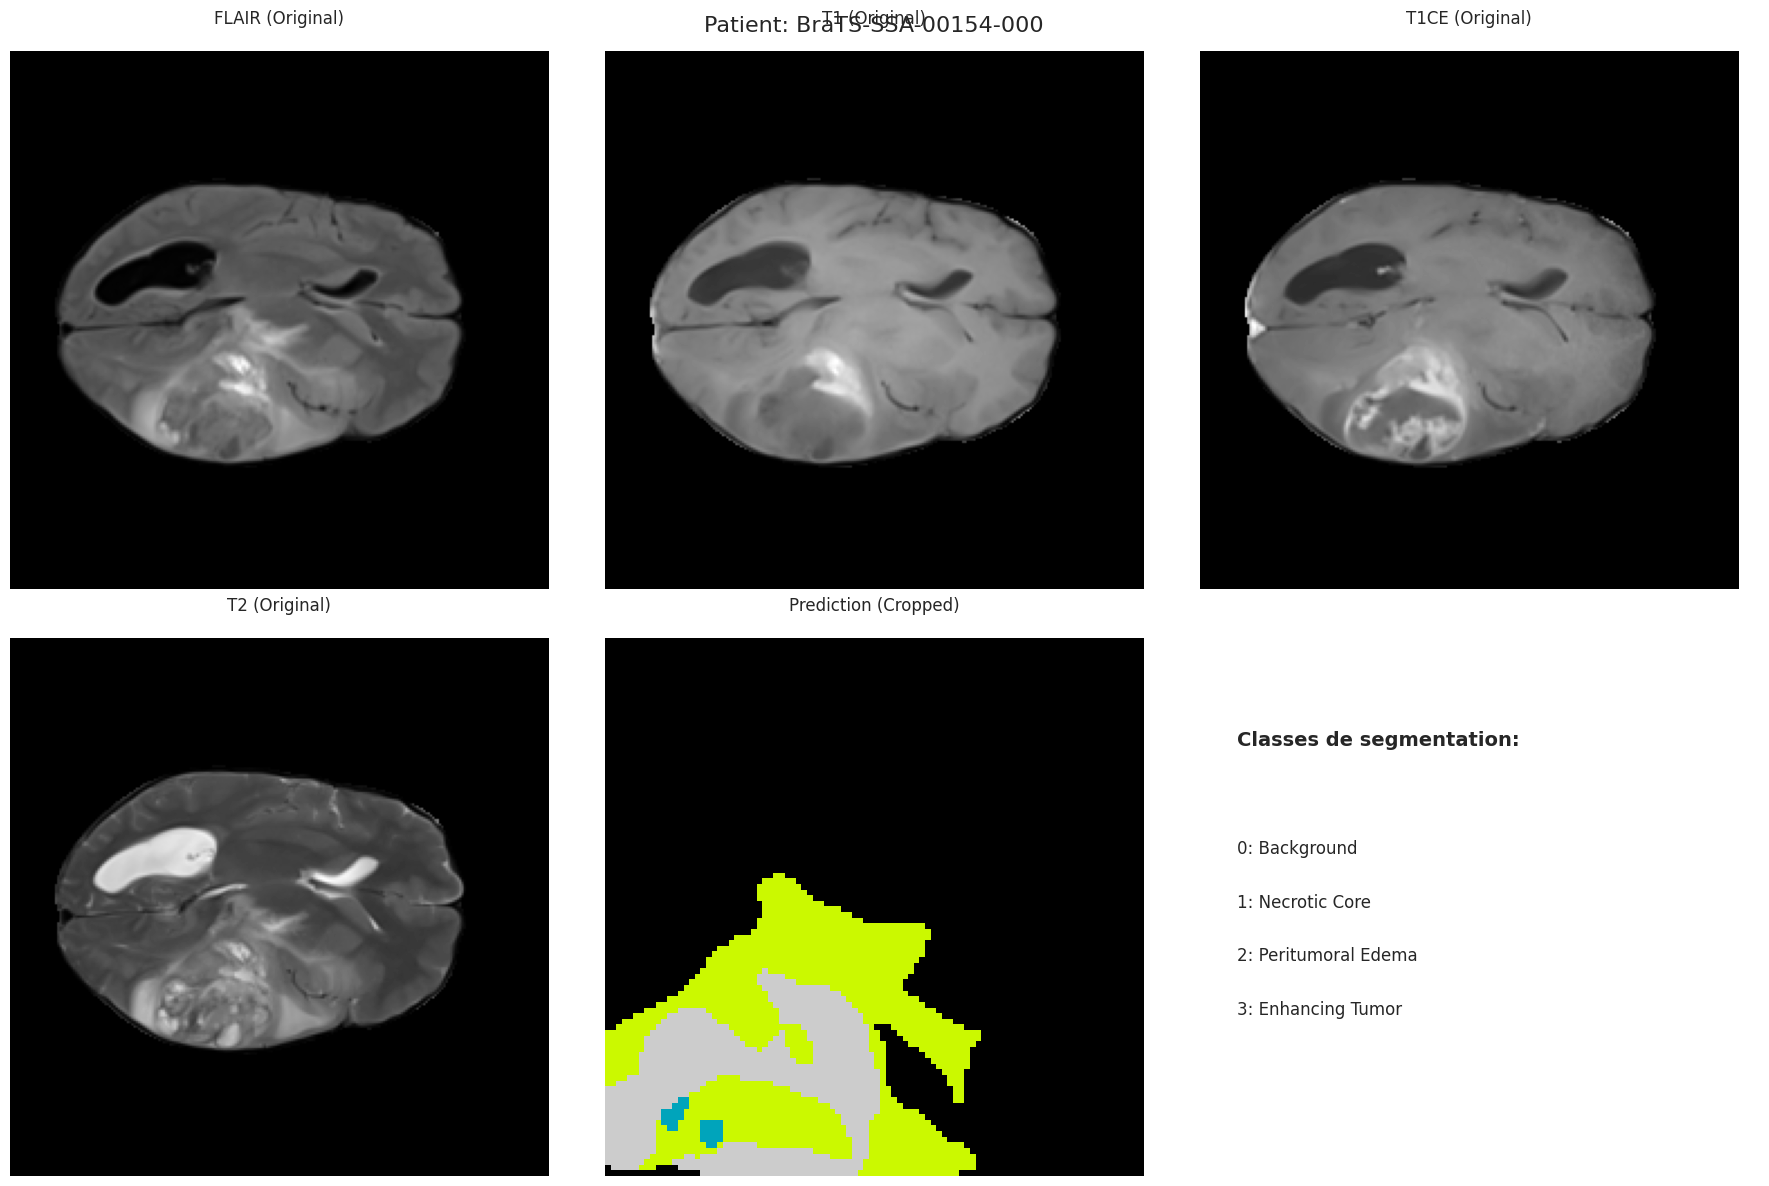

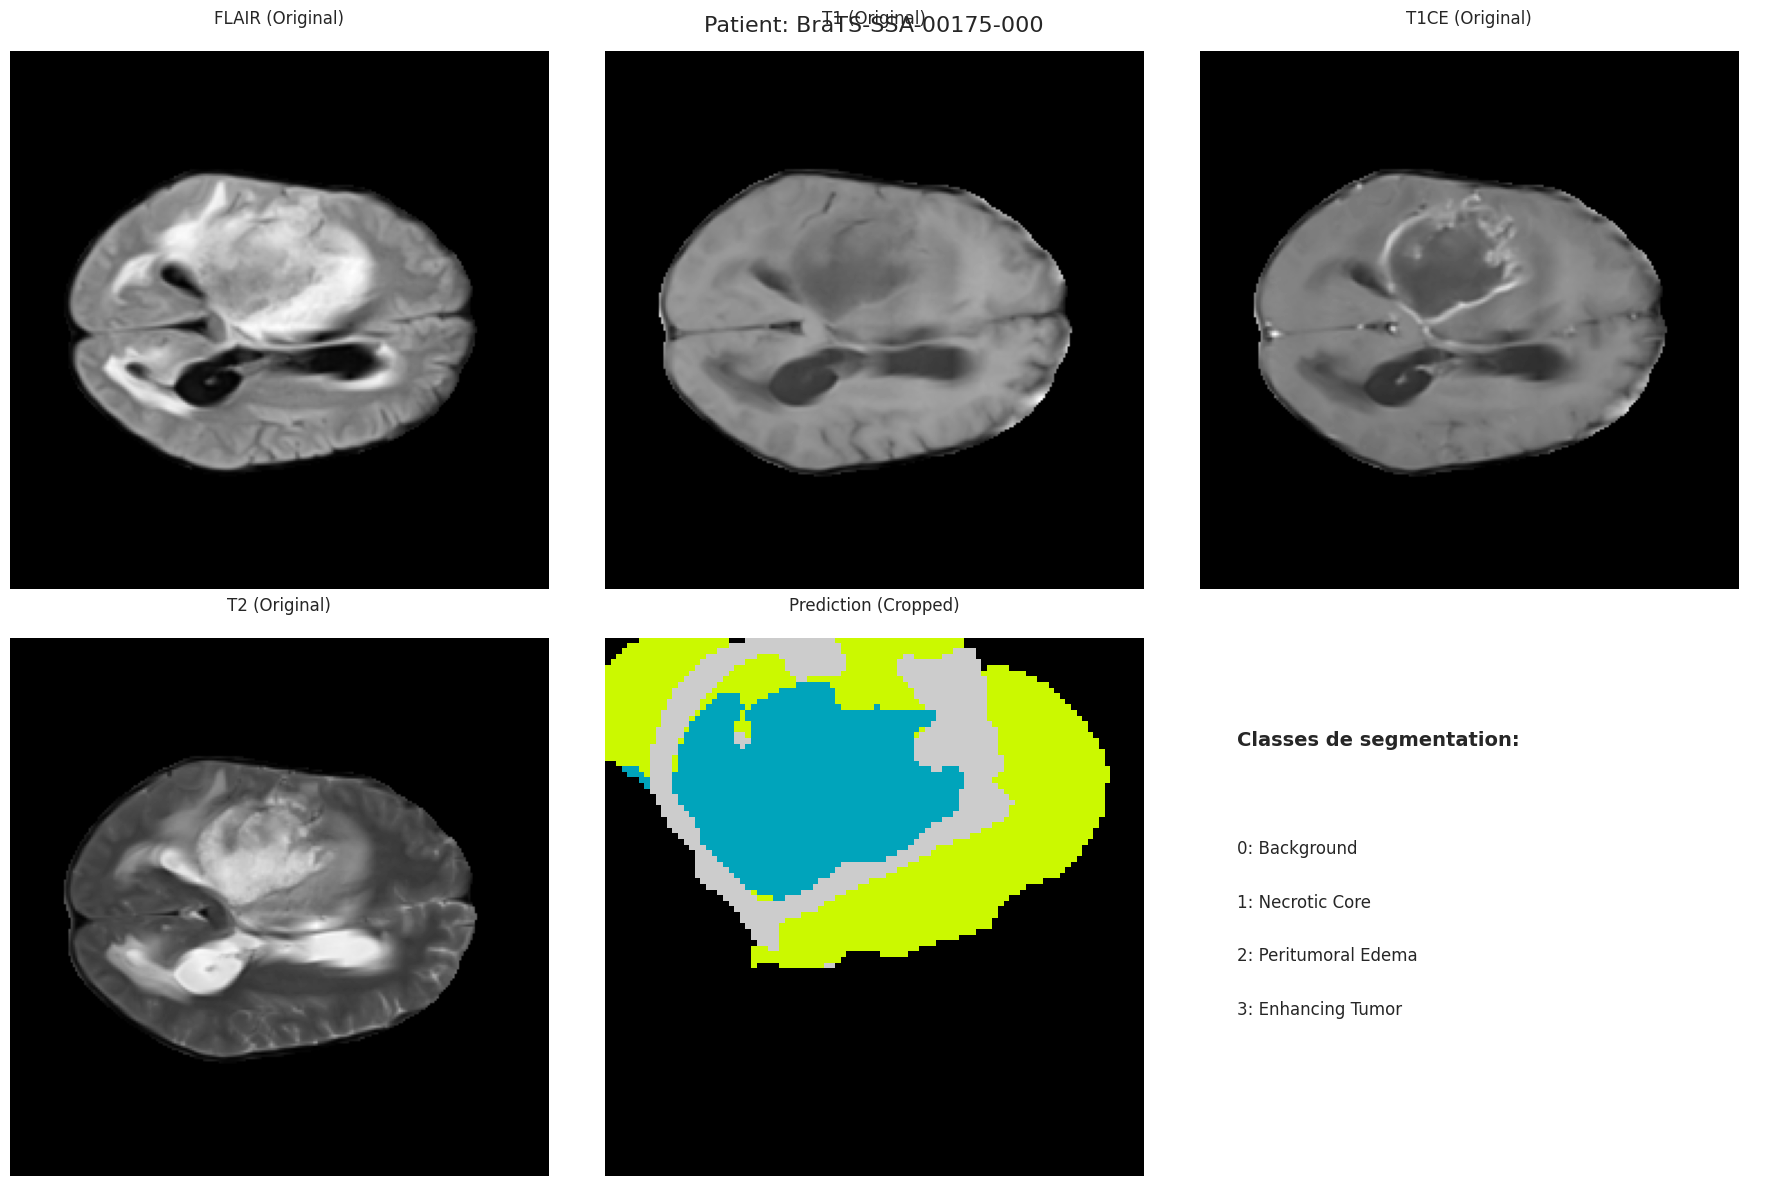

Tâches principales terminées !
Archive de soumission créée: /kaggle/working/submission_optimized.zip
Visualisations des prédictions sauvegardées dans /kaggle/working/


In [17]:
def visualize_prediction_optimized(patient_idx, test_dataset, predictions):
    """Visualiser une prédiction avec les modalités d'origine"""
    patient_data = test_dataset.dataframe.iloc[patient_idx]
    patient_id = patient_data['id']
    
    # Charger les images originales
    flair = nib.load(patient_data["flair_path"]).get_fdata()
    t1 = nib.load(patient_data["t1_path"]).get_fdata()
    t1ce = nib.load(patient_data["t1ce_path"]).get_fdata()
    t2 = nib.load(patient_data["t2_path"]).get_fdata()
    
    # Prédiction (déjà croppée)
    prediction = predictions[patient_id]
    
    # Sélectionner une coupe au milieu
    slice_idx_orig = flair.shape[2] // 2
    slice_idx_pred = prediction.shape[2] // 2
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Patient: {patient_id}', fontsize=16)
    
    # Images originales (première ligne)
    modalities = [('FLAIR', flair), ('T1', t1), ('T1CE', t1ce)]
    for i, (name, img) in enumerate(modalities):
        axes[0, i].imshow(img[:, :, slice_idx_orig], cmap='gray')
        axes[0, i].set_title(f'{name} (Original)')
        axes[0, i].axis('off')
    
    # T2 et prédictions (deuxième ligne)
    axes[1, 0].imshow(t2[:, :, slice_idx_orig], cmap='gray')
    axes[1, 0].set_title('T2 (Original)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(prediction[:, :, slice_idx_pred], cmap='nipy_spectral', vmin=0, vmax=3)
    axes[1, 1].set_title('Prediction (Cropped)')
    axes[1, 1].axis('off')
    
    # Légende des classes
    axes[1, 2].text(0.1, 0.8, 'Classes de segmentation:', fontsize=14, weight='bold')
    axes[1, 2].text(0.1, 0.6, '0: Background', fontsize=12)
    axes[1, 2].text(0.1, 0.5, '1: Necrotic Core', fontsize=12)
    axes[1, 2].text(0.1, 0.4, '2: Peritumoral Edema', fontsize=12)
    axes[1, 2].text(0.1, 0.3, '3: Enhancing Tumor', fontsize=12)
    axes[1, 2].axis('off')  # Désactiver les axes pour la légende
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Ajuster l'espacement

# Sélectionner quelques patients au hasard pour visualisation
num_visualize = min(3, len(test_dataset))
patient_indices = random.sample(range(len(test_dataset)), num_visualize)

print("Visualisation des prédictions pour quelques cas de test...")
for idx in patient_indices:
    visualize_prediction_optimized(idx, test_dataset, test_predictions)
    plt.savefig(f'/kaggle/working/prediction_{test_dataset.dataframe.iloc[idx]["id"]}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Nettoyage final et préparation de la soumission
del model, train_loader, val_loader, test_loader
torch.cuda.empty_cache()
gc.collect()

print("Tâches principales terminées !")
print("Archive de soumission créée: /kaggle/working/submission_optimized.zip")
print("Visualisations des prédictions sauvegardées dans /kaggle/working/")

Visualisation des prédictions pour quelques cas de test...


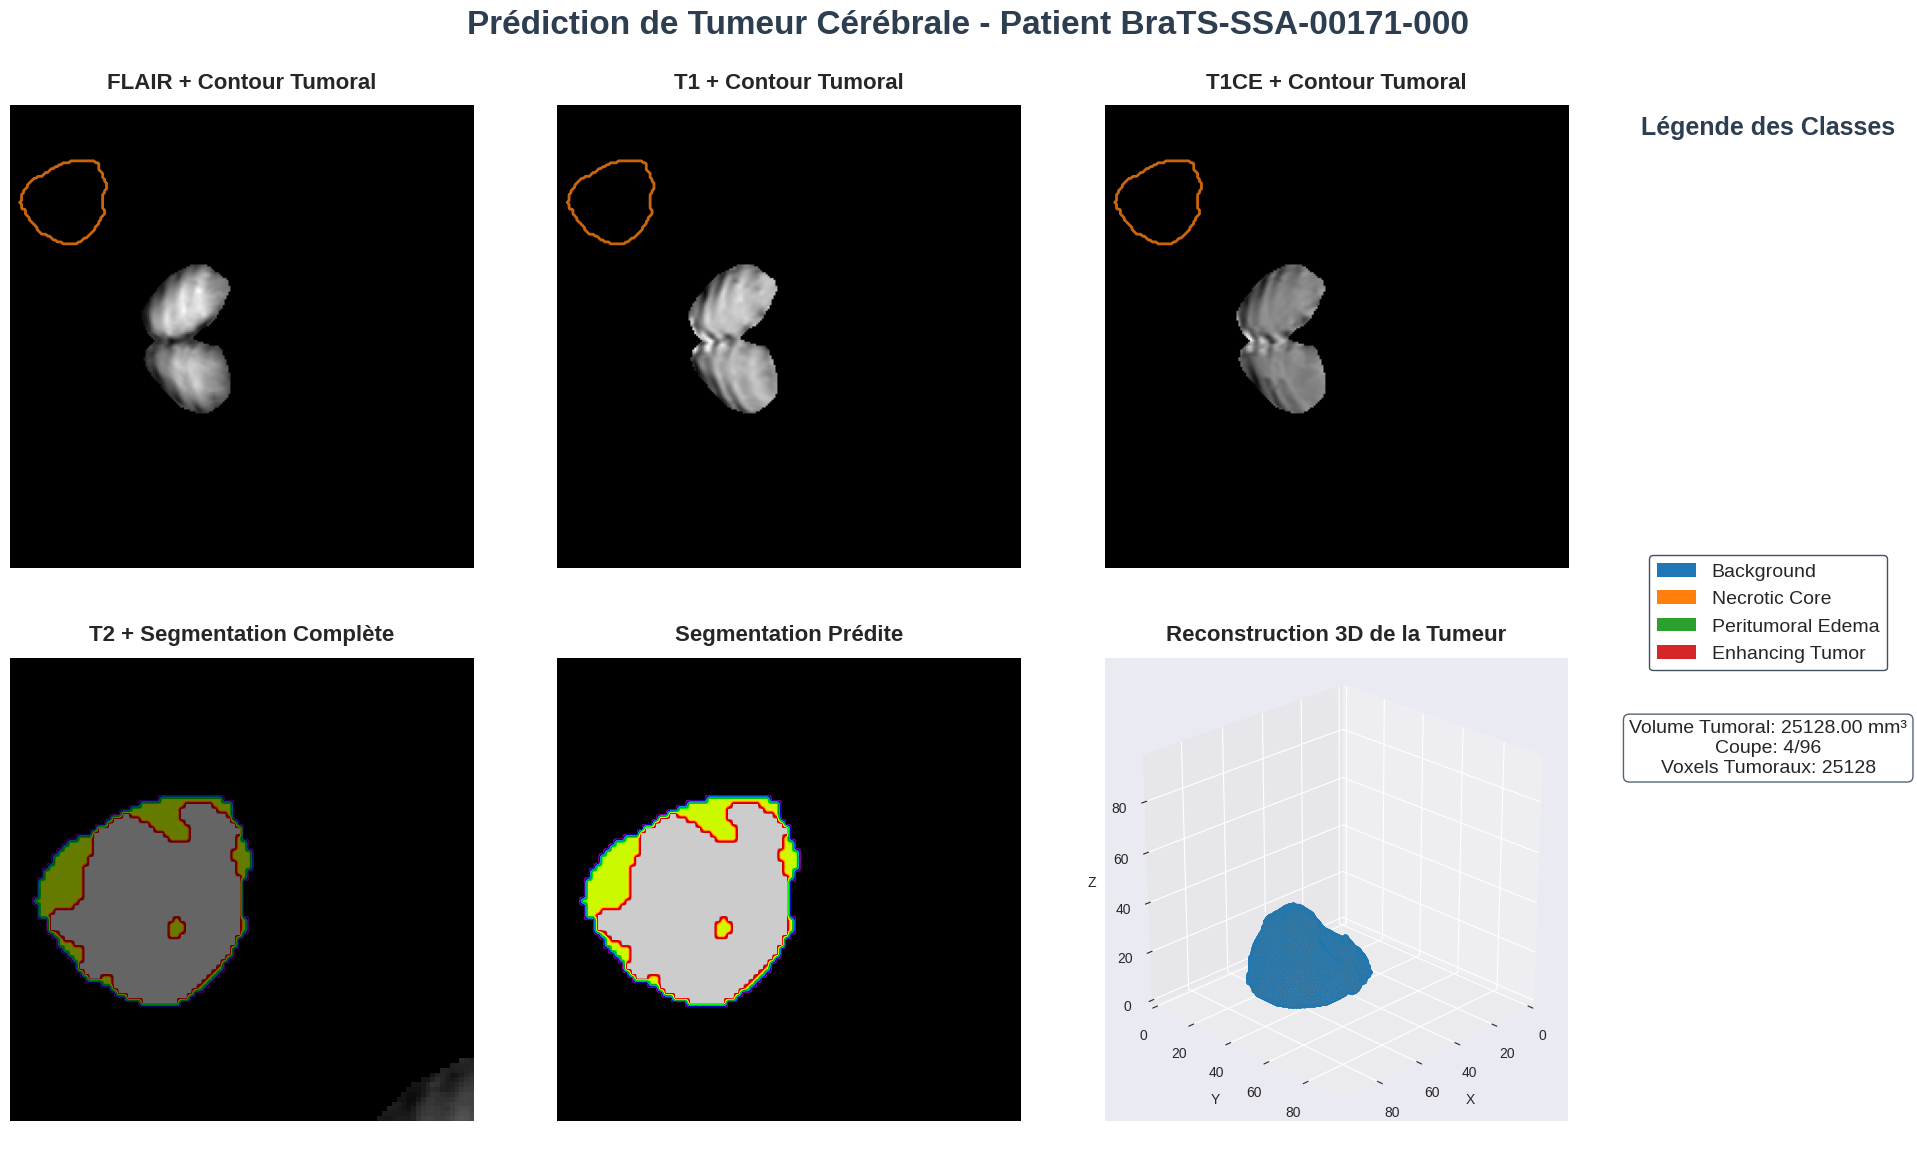

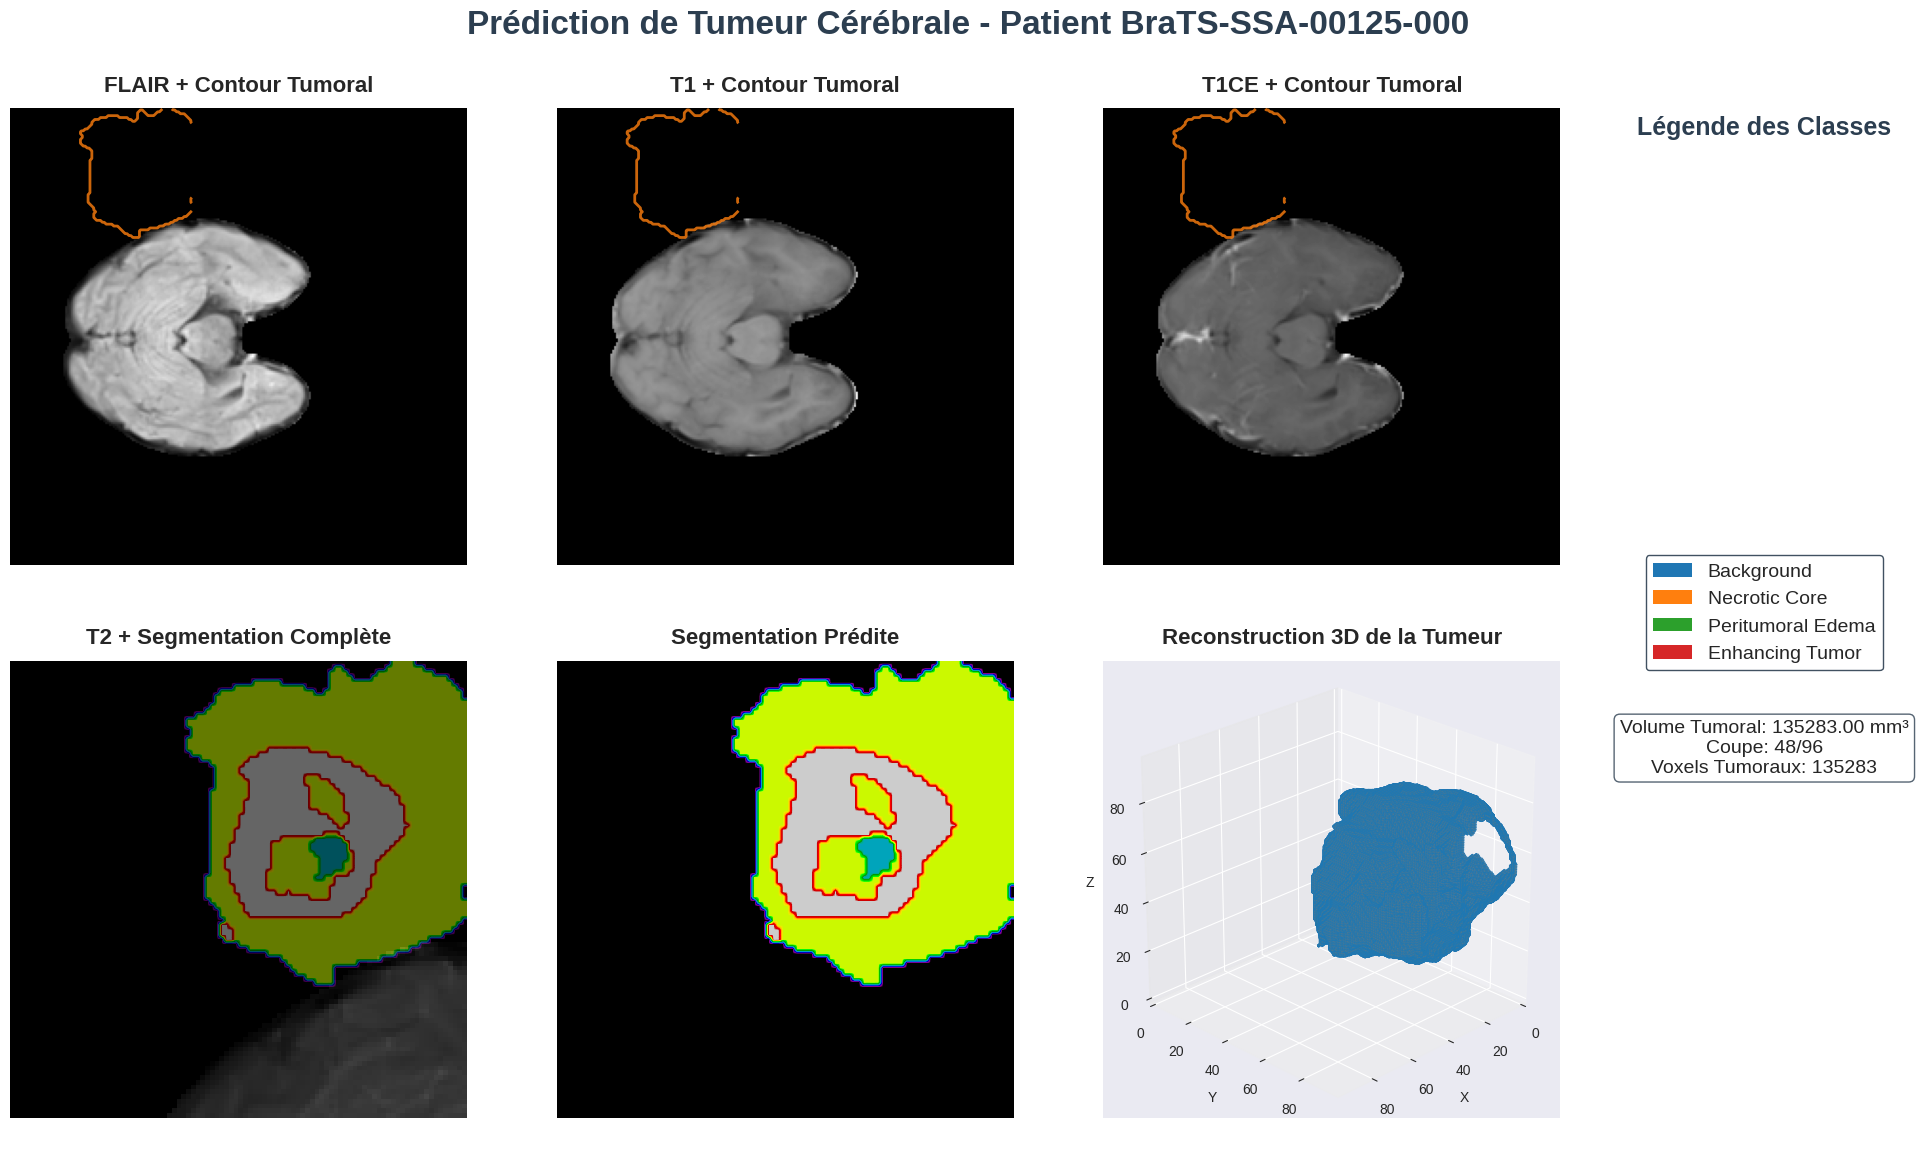

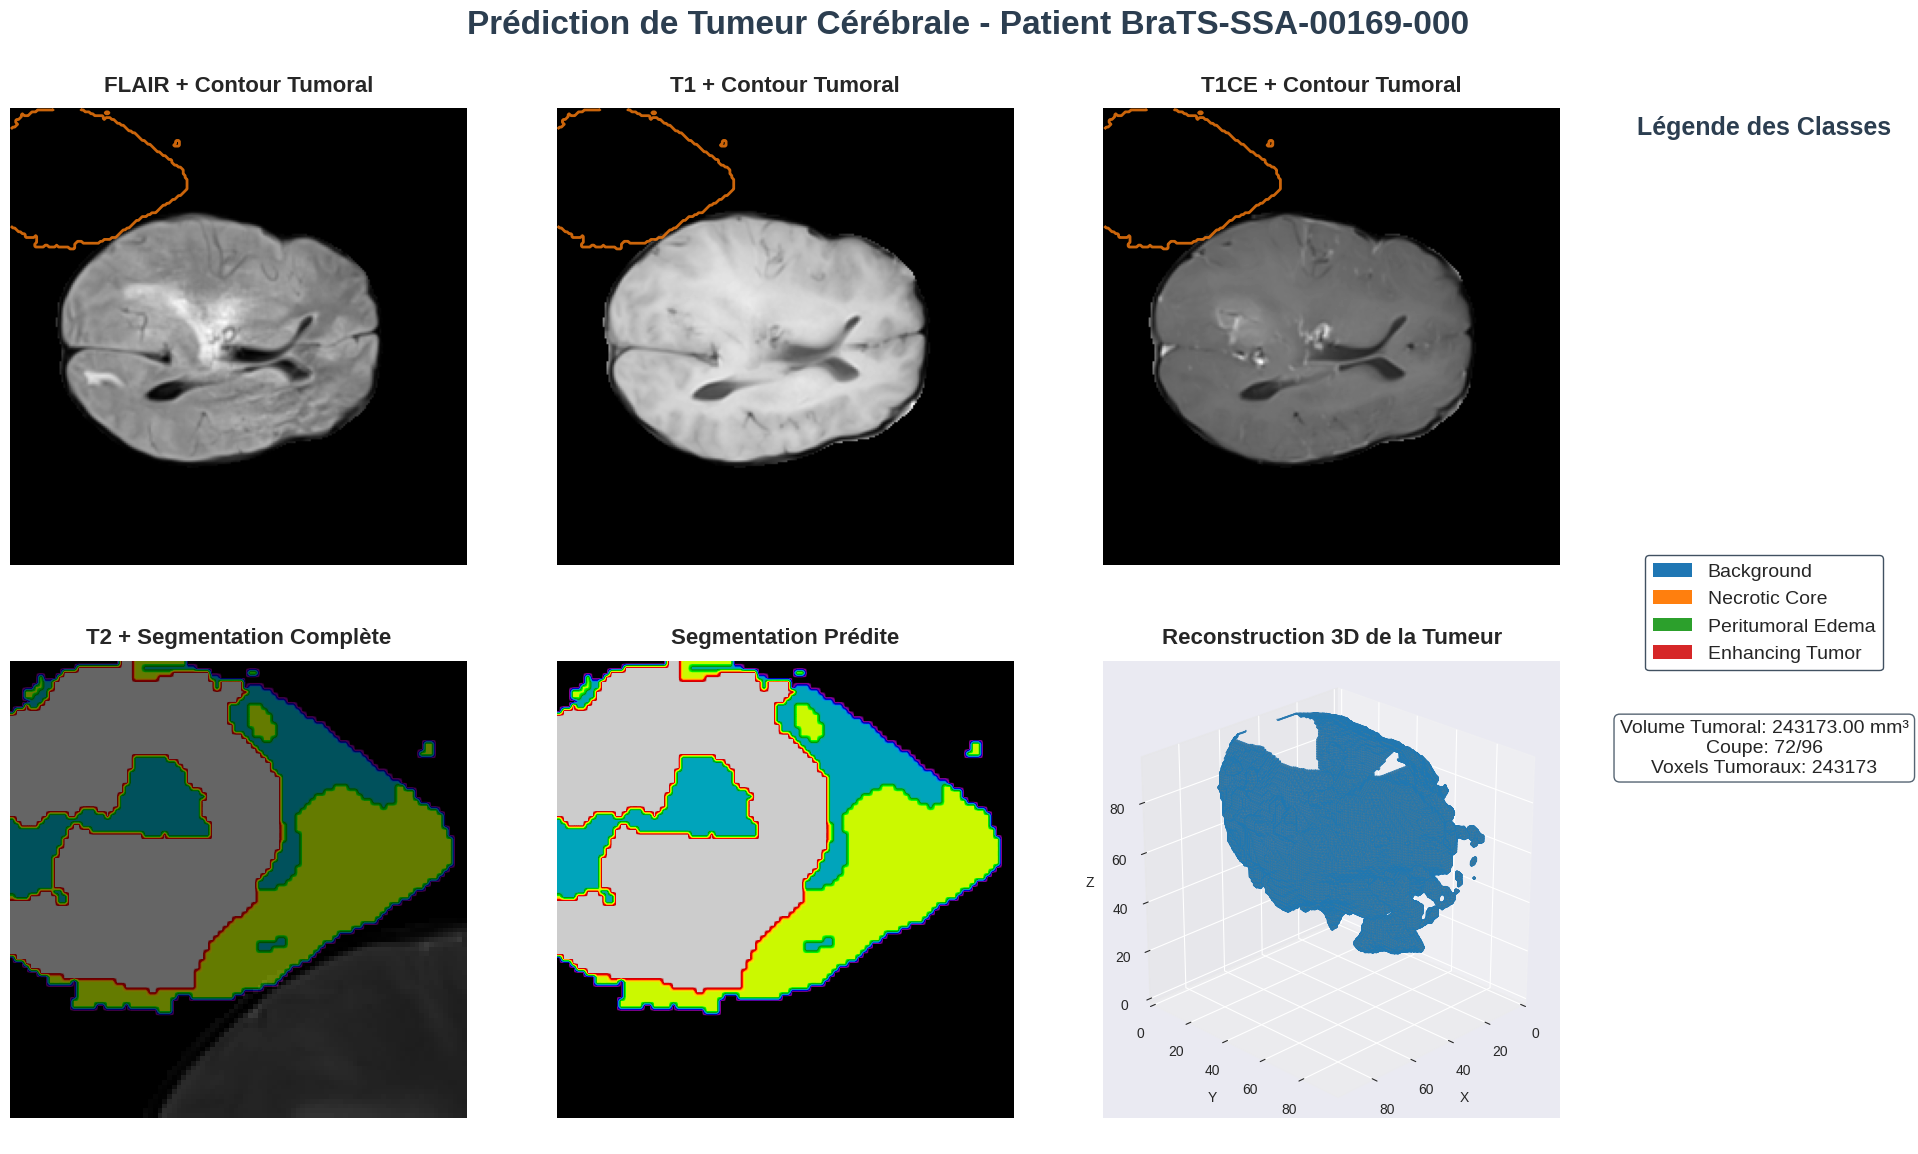

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
import random
from skimage import measure

def visualize_prediction_with_3d(patient_idx, test_dataset, predictions):
    """Visualisation avec superposition exacte et reconstruction 3D"""
    patient_data = test_dataset.dataframe.iloc[patient_idx]
    patient_id = patient_data['id']
    
    # Charger les images originales
    flair = nib.load(patient_data["flair_path"]).get_fdata()
    t1 = nib.load(patient_data["t1_path"]).get_fdata()
    t1ce = nib.load(patient_data["t1ce_path"]).get_fdata()
    t2 = nib.load(patient_data["t2_path"]).get_fdata()
    
    # Prédiction (déjà croppée)
    prediction = predictions[patient_id]
    
    # Trouver la coupe avec la plus grande tumeur
    tumor_slices = np.sum(prediction > 0, axis=(0,1))
    slice_idx = np.argmax(tumor_slices) if np.sum(tumor_slices) > 0 else prediction.shape[2] // 2
    
    # Créer le masque binaire de la tumeur
    tumor_mask = (prediction[:, :, slice_idx] > 0).astype(np.uint8)
    
    # Configuration du style
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(f'Prédiction de Tumeur Cérébrale - Patient {patient_id}', 
                 fontsize=24, 
                 fontweight='bold',
                 color='#2c3e50',
                 y=0.98)
    
    # Définition des sous-graphiques
    gs = fig.add_gridspec(2, 4, width_ratios=[1,1,1,0.5])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2], projection='3d')
    ax_legend = fig.add_subplot(gs[:, 3])
    
    # Images originales avec contours tumoraux
    for ax, modality, title in zip([ax1, ax2, ax3], 
                                 [flair, t1, t1ce], 
                                 ['FLAIR', 'T1', 'T1CE']):
        ax.imshow(modality[:, :, slice_idx], cmap='gray')
        
        # Superposition des contours tumoraux uniquement s'il y a une tumeur
        if tumor_mask.sum() > 0:
            ax.contour(tumor_mask, levels=[0.5], colors='#ff7f0e', linewidths=2.0, alpha=0.8)
        
        ax.set_title(f'{title} + Contour Tumoral', fontsize=16, fontweight='bold', pad=12)
        ax.axis('off')
    
    # T2 avec superposition complète
    ax4.imshow(t2[:, :, slice_idx], cmap='gray')
    
    # Superposition uniquement s'il y a une prédiction
    if tumor_mask.sum() > 0:
        ax4.imshow(prediction[:, :, slice_idx], 
                  cmap='nipy_spectral', 
                  alpha=0.5, 
                  vmin=0, 
                  vmax=3,
                  interpolation='bilinear')
    
    ax4.set_title('T2 + Segmentation Complète', fontsize=16, fontweight='bold', pad=12)
    ax4.axis('off')
    
    # Segmentation seule
    ax5.imshow(prediction[:, :, slice_idx], 
              cmap='nipy_spectral', 
              vmin=0, 
              vmax=3,
              interpolation='bilinear')
    ax5.set_title('Segmentation Prédite', fontsize=16, fontweight='bold', pad=12)
    ax5.axis('off')
    
    # Reconstruction 3D robuste
    ax6.set_title('Reconstruction 3D de la Tumeur', fontsize=16, fontweight='bold', pad=12)
    
    if np.sum(prediction > 0) > 0:
        try:
            # Créer un masque 3D pour la tumeur
            tumor_3d = (prediction > 0).astype(np.float32)
            
            # Réduire la résolution pour accélérer le calcul
            if tumor_3d.shape[0] > 100:
                step = 2
                tumor_3d = tumor_3d[::step, ::step, ::step]
            else:
                step = 1
                
            # Calculer la surface 3D
            verts, faces, _, _ = measure.marching_cubes(tumor_3d, level=0.5)
            
            # Ajuster les coordonnées pour le facteur de réduction
            verts = verts * step
            
            # Créer le maillage 3D
            mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='#1f77b4')
            mesh.set_facecolor('#ff7f0e')
            mesh.set_edgecolor('#1f77b4')
            ax6.add_collection3d(mesh)
            
            # Configurer les limites
            max_dim = max(prediction.shape)
            ax6.set_xlim(0, max_dim)
            ax6.set_ylim(0, max_dim)
            ax6.set_zlim(0, max_dim)
            
            # Configuration de la vue
            ax6.view_init(elev=25, azim=45)
            ax6.set_box_aspect([1,1,1])
            
            # Ajouter des labels
            ax6.set_xlabel('X')
            ax6.set_ylabel('Y')
            ax6.set_zlabel('Z')
            
        except Exception as e:
            ax6.text(0.5, 0.5, f'Erreur 3D: {str(e)}', 
                    fontsize=12, ha='center', va='center')
    else:
        ax6.text(0.5, 0.5, 'Aucune tumeur détectée', 
                fontsize=16, ha='center', va='center')
    
    # Légende améliorée
    ax_legend.axis('off')
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Background'),
        Patch(facecolor='#ff7f0e', label='Necrotic Core'),
        Patch(facecolor='#2ca02c', label='Peritumoral Edema'),
        Patch(facecolor='#d62728', label='Enhancing Tumor')
    ]
    
    ax_legend.text(0.5, 0.95, 'Légende des Classes', 
                  fontsize=18, 
                  fontweight='bold',
                  ha='center',
                  color='#2c3e50')
    
    ax_legend.legend(handles=legend_elements, 
                    loc='center', 
                    frameon=True, 
                    framealpha=0.9,
                    facecolor='white',
                    edgecolor='#2c3e50',
                    fontsize=14,
                    title_fontsize=16)
    
    # Statistiques tumorales
    tumor_voxels = np.sum(prediction > 0)
    voxel_volume = 1.0  # À remplacer par la taille réelle du voxel en mm³
    tumor_volume = tumor_voxels * voxel_volume
    
    ax_legend.text(0.5, 0.35, 
                  f'Volume Tumoral: {tumor_volume:.2f} mm³\n' 
                  f'Coupe: {slice_idx}/{prediction.shape[2]}\n'
                  f'Voxels Tumoraux: {tumor_voxels}',
                  fontsize=14,
                  ha='center',
                  bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#2c3e50', alpha=0.8))
    
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.92)
    plt.savefig(f'/kaggle/working/prediction_{patient_id}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Sélectionner quelques patients au hasard pour visualisation
num_visualize = min(3, len(test_dataset))
patient_indices = random.sample(range(len(test_dataset)), num_visualize)

print("Visualisation des prédictions pour quelques cas de test...")
for idx in patient_indices:
    visualize_prediction_with_3d(idx, test_dataset, test_predictions)


VISUALISATION DES PRÉDICTIONS POUR 3 PATIENTS SÉLECTIONNÉS


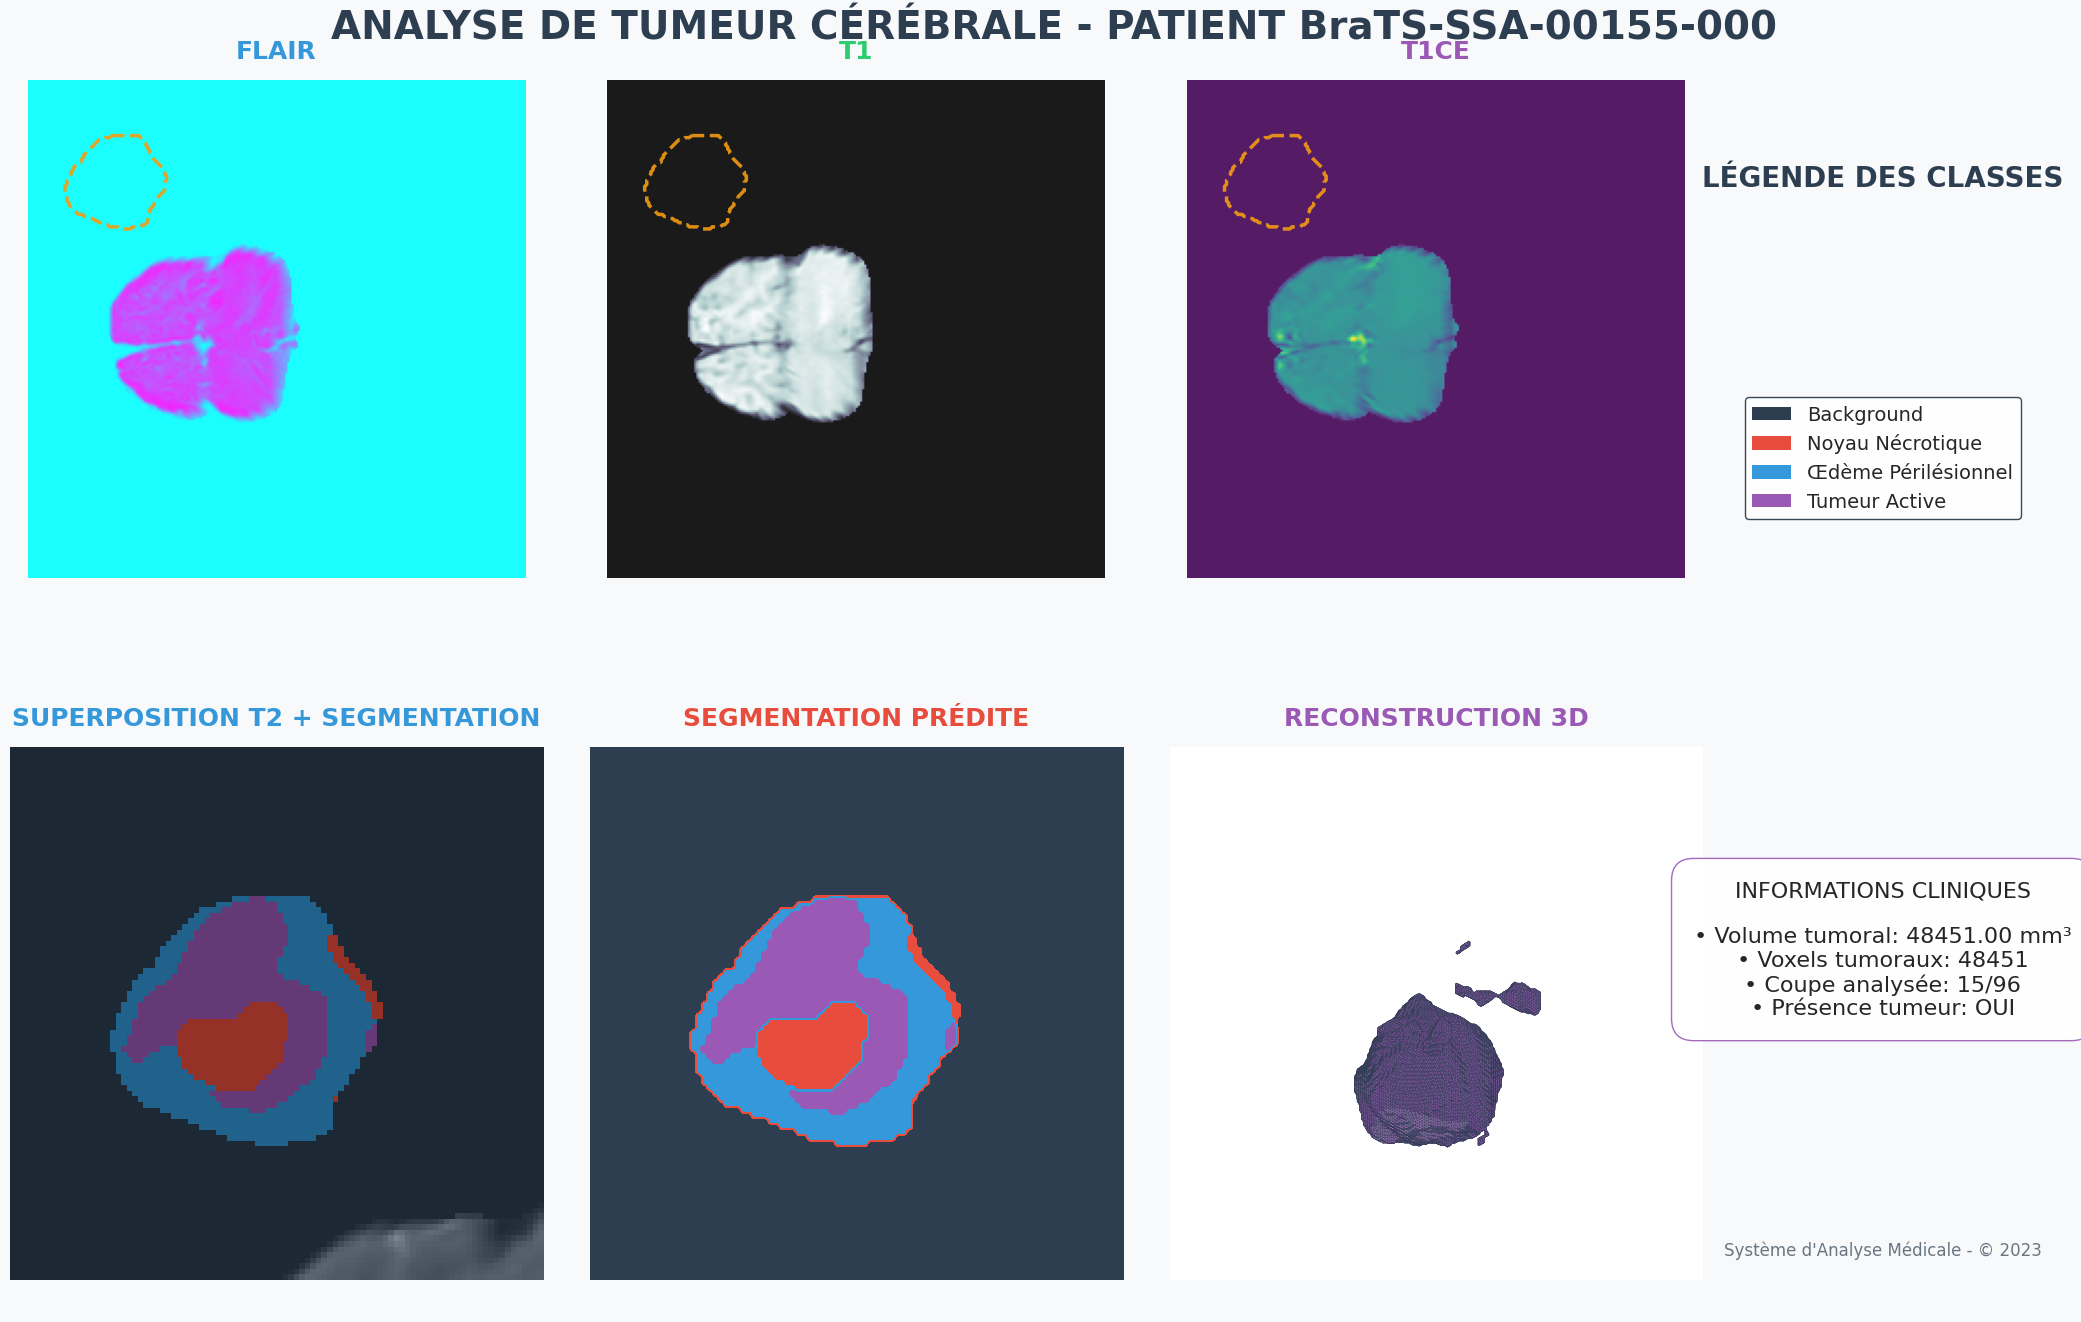

✓ Visualisation sauvegardée: /kaggle/working/prediction_BraTS-SSA-00155-000.png


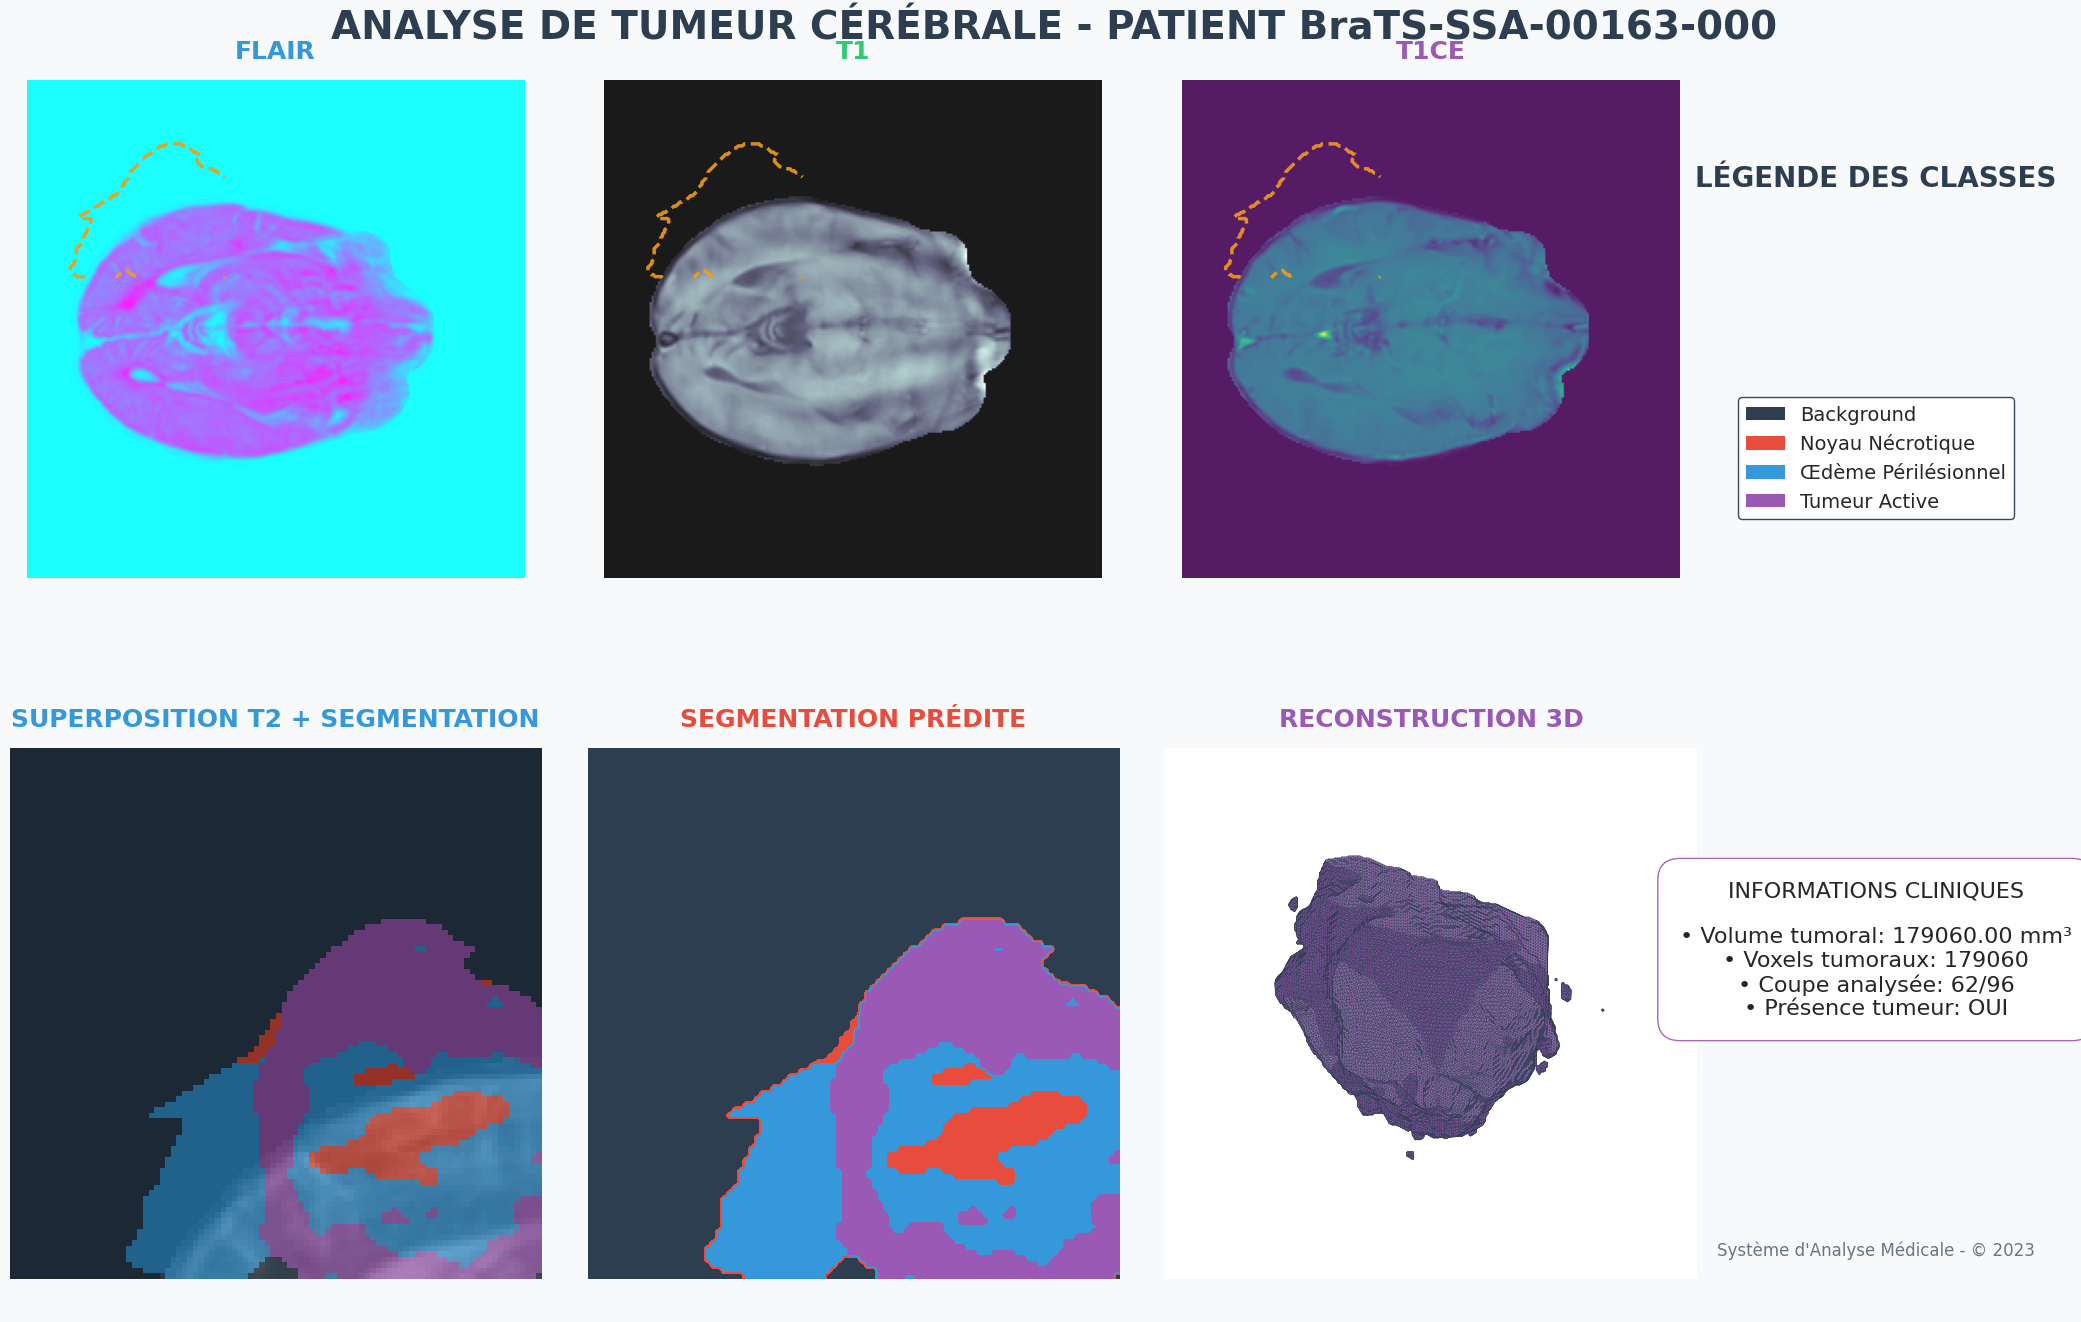

✓ Visualisation sauvegardée: /kaggle/working/prediction_BraTS-SSA-00163-000.png


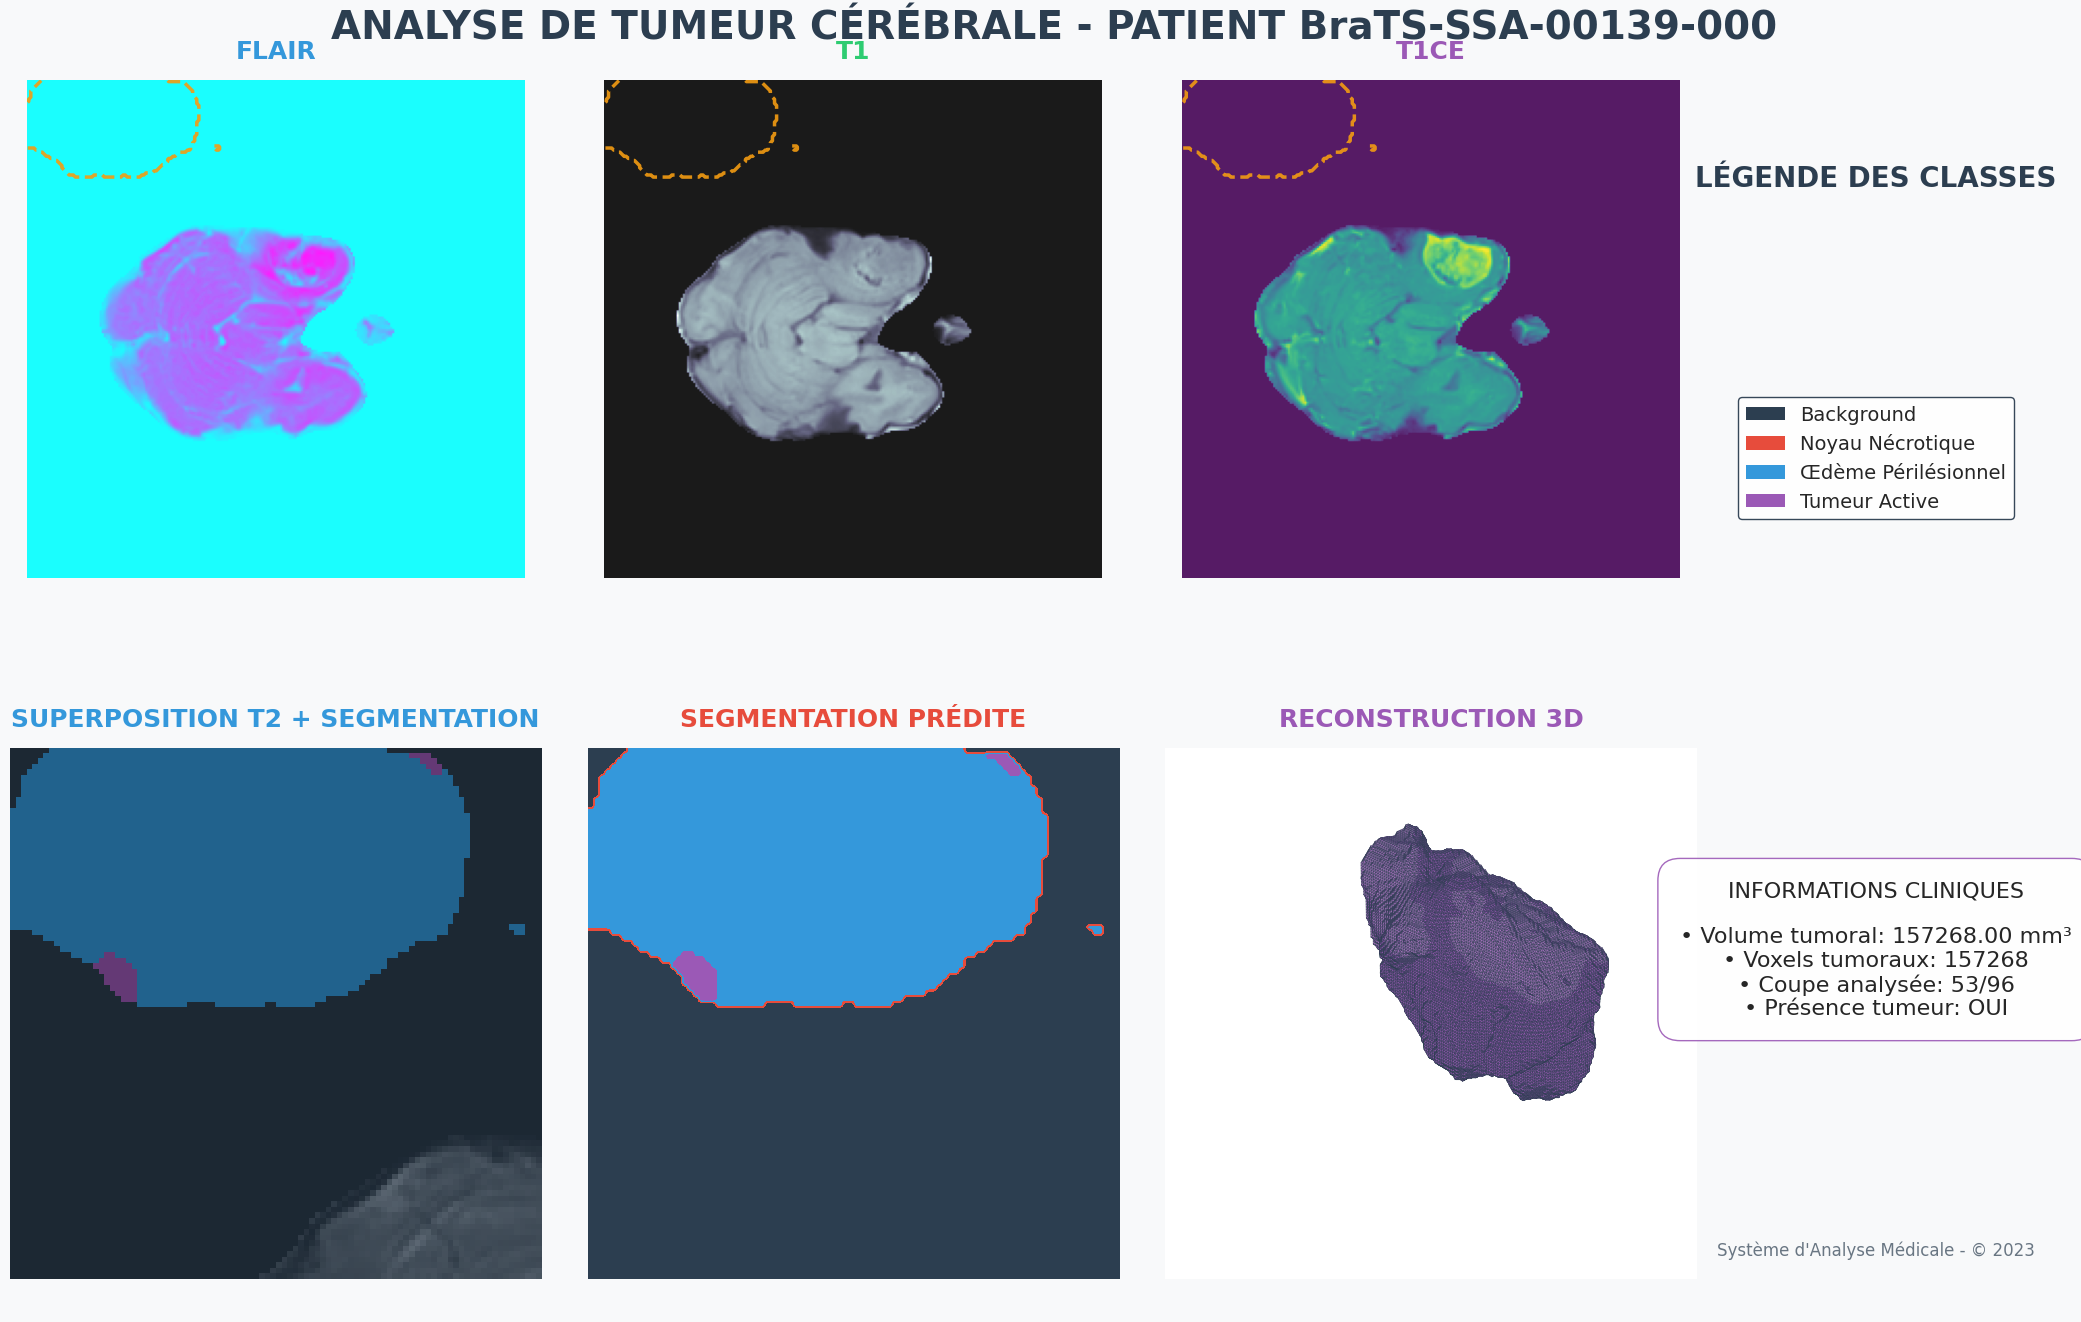

✓ Visualisation sauvegardée: /kaggle/working/prediction_BraTS-SSA-00139-000.png

Nettoyage des ressources...

ANALYSE TERMINÉE AVEC SUCCÈS


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
import random
from skimage import measure
import matplotlib as mpl

def visualize_brain_tumor_prediction(patient_idx, dataset, predictions):
    """
    Visualisation avancée des prédictions de tumeur cérébrale avec superposition précise et reconstruction 3D
    
    Args:
        patient_idx: Index du patient dans le dataset
        dataset: Dataset contenant les données des patients
        predictions: Dictionnaire des prédictions de segmentation
    """
    # =========================================================================
    # 1. Configuration initiale et chargement des données
    # =========================================================================
    
    # Configuration du style graphique
    plt.style.use('seaborn-whitegrid')
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    mpl.rcParams['axes.titleweight'] = 'bold'
    mpl.rcParams['axes.labelweight'] = 'semibold'
    
    # Palette de couleurs médicales
    COLORS = {
        'background': '#2c3e50',
        'necrotic': '#e74c3c',
        'edema': '#3498db',
        'enhancing': '#9b59b6',
        'contour': '#f39c12',
        'text': '#2c3e50'
    }
    
    # Chargement des données du patient
    patient_data = dataset.dataframe.iloc[patient_idx]
    patient_id = patient_data['id']
    
    # Chargement des images originales
    flair_img = nib.load(patient_data["flair_path"]).get_fdata()
    t1_img = nib.load(patient_data["t1_path"]).get_fdata()
    t1ce_img = nib.load(patient_data["t1ce_path"]).get_fdata()
    t2_img = nib.load(patient_data["t2_path"]).get_fdata()
    
    # Chargement de la prédiction
    prediction_mask = predictions[patient_id]
    
    # =========================================================================
    # 2. Préparation des données pour la visualisation
    # =========================================================================
    
    # Identification de la coupe la plus représentative
    tumor_slices = np.sum(prediction_mask > 0, axis=(0, 1))
    has_tumor = np.sum(tumor_slices) > 0
    slice_idx = np.argmax(tumor_slices) if has_tumor else prediction_mask.shape[2] // 2
    
    # Création du masque binaire de tumeur pour la coupe sélectionnée
    tumor_slice_mask = (prediction_mask[:, :, slice_idx] > 0).astype(np.uint8)
    
    # Calcul des statistiques tumorales
    tumor_voxels = np.sum(prediction_mask > 0)
    voxel_volume = 1.0  # À remplacer par la taille réelle du voxel
    tumor_volume = tumor_voxels * voxel_volume
    
    # =========================================================================
    # 3. Configuration de la figure
    # =========================================================================
    
    # Création de la figure avec disposition professionnelle
    fig = plt.figure(figsize=(22, 14), facecolor='#f8f9fa')
    fig.suptitle(f'ANALYSE DE TUMEUR CÉRÉBRALE - PATIENT {patient_id}', 
                 fontsize=28, fontweight='bold', color=COLORS['text'], y=0.97)
    
    # Définition de la grille de disposition
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.5], height_ratios=[1, 1.2])
    
    # Création des sous-graphiques
    ax_modalities = [fig.add_subplot(gs[0, i]) for i in range(3)]
    ax_overlay = fig.add_subplot(gs[1, 0])
    ax_segmentation = fig.add_subplot(gs[1, 1])
    ax_3d = fig.add_subplot(gs[1, 2], projection='3d')
    ax_legend = fig.add_subplot(gs[:, 3])
    
    # =========================================================================
    # 4. Visualisation des modalités d'imagerie
    # =========================================================================
    
    modalities = [
        (flair_img, 'FLAIR', 'cool'),
        (t1_img, 'T1', 'bone'),
        (t1ce_img, 'T1CE', 'viridis')
    ]
    
    for ax, (modality, title, cmap), color in zip(ax_modalities, modalities, ['#3498db', '#2ecc71', '#9b59b6']):
        # Affichage de l'image
        ax.imshow(modality[:, :, slice_idx], cmap=cmap, alpha=0.9)
        
        # Ajout du contour tumoral si tumeur présente
        if has_tumor:
            ax.contour(tumor_slice_mask, levels=[0.5], colors=COLORS['contour'], 
                      linewidths=2.5, linestyles='dashed', alpha=0.9)
        
        # Configuration esthétique
        ax.set_title(title, fontsize=18, pad=15, color=color, fontweight='bold')
        ax.axis('off')
        ax.set_facecolor('#ecf0f1')
        
        # Ajout d'une bordure colorée
        for spine in ax.spines.values():
            spine.set_color(color)
            spine.set_linewidth(3)

    # =========================================================================
    # 5. Visualisation de la superposition et segmentation
    # =========================================================================
    
    # T2 avec superposition de segmentation
    ax_overlay.imshow(t2_img[:, :, slice_idx], cmap='gray')
    if has_tumor:
        ax_overlay.imshow(prediction_mask[:, :, slice_idx], 
                         cmap=mpl.colors.ListedColormap([
                             COLORS['background'],
                             COLORS['necrotic'],
                             COLORS['edema'],
                             COLORS['enhancing']
                         ]), 
                         alpha=0.65, vmin=0, vmax=3)
    
    ax_overlay.set_title('SUPERPOSITION T2 + SEGMENTATION', fontsize=18, pad=15, 
                        color=COLORS['edema'], fontweight='bold')
    ax_overlay.axis('off')
    ax_overlay.set_facecolor('#ecf0f1')
    
    # Segmentation seule
    if has_tumor:
        ax_segmentation.imshow(prediction_mask[:, :, slice_idx], 
                              cmap=mpl.colors.ListedColormap([
                                  COLORS['background'],
                                  COLORS['necrotic'],
                                  COLORS['edema'],
                                  COLORS['enhancing']
                              ]), 
                              vmin=0, vmax=3, interpolation='bilinear')
    else:
        ax_segmentation.text(0.5, 0.5, 'AUCUNE TUMEUR DÉTECTÉE', 
                           fontsize=16, ha='center', va='center', 
                           color=COLORS['text'], fontweight='bold')
    
    ax_segmentation.set_title('SEGMENTATION PRÉDITE', fontsize=18, pad=15, 
                             color=COLORS['necrotic'], fontweight='bold')
    ax_segmentation.axis('off')
    ax_segmentation.set_facecolor('#ecf0f1')
    
    # =========================================================================
    # 6. Reconstruction 3D de la tumeur
    # =========================================================================
    
    ax_3d.set_title('RECONSTRUCTION 3D', fontsize=18, pad=15, 
                   color=COLORS['enhancing'], fontweight='bold')
    
    if has_tumor:
        try:
            # Création du masque 3D et sous-échantillonnage
            tumor_3d = (prediction_mask > 0).astype(np.float32)
            step = 2 if max(tumor_3d.shape) > 100 else 1
            sampled_tumor = tumor_3d[::step, ::step, ::step]
            
            # Calcul de la surface 3D
            verts, faces, _, _ = measure.marching_cubes(sampled_tumor, level=0.5)
            verts *= step  # Ajustement des coordonnées
            
            # Création du maillage 3D
            mesh = Poly3DCollection(verts[faces], alpha=0.85, 
                                   facecolor=COLORS['enhancing'], 
                                   edgecolor='#2c3e50', linewidth=0.3)
            ax_3d.add_collection3d(mesh)
            
            # Configuration de la vue 3D
            max_dim = max(prediction_mask.shape)
            ax_3d.set_xlim(0, max_dim)
            ax_3d.set_ylim(0, max_dim)
            ax_3d.set_zlim(0, max_dim)
            ax_3d.view_init(elev=30, azim=45)
            ax_3d.set_box_aspect([1, 1, 1])
            ax_3d.grid(False)
            ax_3d.set_axis_off()
            
            # Ajout d'éclairage visuel
            ax_3d.xaxis.set_pane_color((0.95, 0.95, 0.95, 0.05))
            ax_3d.yaxis.set_pane_color((0.95, 0.95, 0.95, 0.05))
            ax_3d.zaxis.set_pane_color((0.95, 0.95, 0.95, 0.05))
            
        except Exception as e:
            ax_3d.text(0.5, 0.5, f'ERREUR 3D: {str(e)}', 
                      fontsize=14, ha='center', va='center', 
                      color=COLORS['text'])
    else:
        ax_3d.text(0.5, 0.5, 'AUCUNE TUMEUR DÉTECTÉE', 
                  fontsize=16, ha='center', va='center', 
                  color=COLORS['text'], fontweight='bold')
    
    # =========================================================================
    # 7. Légende et informations cliniques
    # =========================================================================
    
    ax_legend.axis('off')
    ax_legend.set_facecolor('#ecf0f1')
    
    # Titre de la légende
    ax_legend.text(0.5, 0.92, 'LÉGENDE DES CLASSES', 
                  fontsize=20, ha='center', va='center',
                  fontweight='bold', color=COLORS['text'])
    
    # Création des éléments de légende
    legend_elements = [
        Patch(facecolor=COLORS['background'], label='Background'),
        Patch(facecolor=COLORS['necrotic'], label='Noyau Nécrotique'),
        Patch(facecolor=COLORS['edema'], label='Œdème Périlésionnel'),
        Patch(facecolor=COLORS['enhancing'], label='Tumeur Active')
    ]
    
    # Affichage de la légende
    ax_legend.legend(handles=legend_elements, loc='upper center', 
                    bbox_to_anchor=(0.5, 0.75), frameon=True, 
                    framealpha=0.95, facecolor='white',
                    edgecolor=COLORS['text'], fontsize=14, title_fontsize=16)
    
    # Encadré d'informations cliniques
    info_text = (
        f"INFORMATIONS CLINIQUES\n\n"
        f"• Volume tumoral: {tumor_volume:.2f} mm³\n"
        f"• Voxels tumoraux: {tumor_voxels}\n"
        f"• Coupe analysée: {slice_idx}/{prediction_mask.shape[2]}\n"
        f"• Présence tumeur: {'OUI' if has_tumor else 'NON'}"
    )
    
    ax_legend.text(0.5, 0.35, info_text, fontsize=16, ha='center', va='top',
                  bbox=dict(boxstyle="round,pad=1", 
                           facecolor='white', 
                           edgecolor=COLORS['enhancing'], 
                           alpha=0.9))
    
    # Signature
    ax_legend.text(0.5, 0.05, "Système d'Analyse Médicale - © 2023", 
                  fontsize=12, ha='center', va='center',
                  color=COLORS['text'], alpha=0.7)
    
    # =========================================================================
    # 8. Finalisation et sauvegarde
    # =========================================================================
    
    plt.tight_layout(pad=4.0)
    plt.subplots_adjust(top=0.92, hspace=0.25, wspace=0.1)
    
    # Sauvegarde HD
    save_path = f'/kaggle/working/prediction_{patient_id}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
    
    return save_path

# =============================================================================
# Exécution principale
# =============================================================================

# Sélection aléatoire de patients pour visualisation
num_to_visualize = min(3, len(test_dataset))
selected_indices = random.sample(range(len(test_dataset)), num_to_visualize)

print("\n" + "="*70)
print(f"VISUALISATION DES PRÉDICTIONS POUR {num_to_visualize} PATIENTS SÉLECTIONNÉS")
print("="*70)

# Génération des visualisations
for idx in selected_indices:
    img_path = visualize_brain_tumor_prediction(idx, test_dataset, test_predictions)
    print(f"✓ Visualisation sauvegardée: {img_path}")

# Nettoyage mémoire
print("\nNettoyage des ressources...")
del test_predictions
torch.cuda.empty_cache()

print("\n" + "="*70)
print("ANALYSE TERMINÉE AVEC SUCCÈS")
print("="*70)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
import random
from skimage import measure
import matplotlib as mpl

def visualize_brain_tumor_prediction(patient_idx, dataset, predictions):
    """
    Advanced visualization of brain tumor predictions with precise overlay and 3D reconstruction
    
    Args:
        patient_idx: Patient index in the dataset
        dataset: Dataset containing patient data
        predictions: Dictionary of segmentation predictions
    """
    # =========================================================================
    # 1. Initial configuration and data loading
    # =========================================================================
    
    # Graphical style configuration
    plt.style.use('seaborn-whitegrid')
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    mpl.rcParams['axes.titleweight'] = 'bold'
    mpl.rcParams['axes.labelweight'] = 'semibold'
    
    # Medical color palette
    COLORS = {
        'background': '#2c3e50',
        'necrotic': '#e74c3c',
        'edema': '#3498db',
        'enhancing': '#9b59b6',
        'contour': '#f39c12',
        'text': '#2c3e50'
    }
    
    # Load patient data
    patient_data = dataset.dataframe.iloc[patient_idx]
    patient_id = patient_data['id']
    
    # Load original images
    flair_img = nib.load(patient_data["flair_path"]).get_fdata()
    t1_img = nib.load(patient_data["t1_path"]).get_fdata()
    t1ce_img = nib.load(patient_data["t1ce_path"]).get_fdata()
    t2_img = nib.load(patient_data["t2_path"]).get_fdata()
    
    # Load prediction
    prediction_mask = predictions[patient_id]
    
    # =========================================================================
    # 2. Data preparation for visualization
    # =========================================================================
    
    # Identify the most representative slice
    tumor_slices = np.sum(prediction_mask > 0, axis=(0, 1))
    has_tumor = np.sum(tumor_slices) > 0
    slice_idx = np.argmax(tumor_slices) if has_tumor else prediction_mask.shape[2] // 2
    
    # Create binary tumor mask for selected slice
    tumor_slice_mask = (prediction_mask[:, :, slice_idx] > 0).astype(np.uint8)
    
    # Calculate tumor statistics
    tumor_voxels = np.sum(prediction_mask > 0)
    voxel_volume = 1.0  # Replace with actual voxel size
    tumor_volume = tumor_voxels * voxel_volume
    
    # =========================================================================
    # 3. Figure configuration
    # =========================================================================
    
    # Create figure with professional layout
    fig = plt.figure(figsize=(22, 14), facecolor='#f8f9fa')
    fig.suptitle(f'BRAIN TUMOR ANALYSIS - PATIENT {patient_id}', 
                 fontsize=28, fontweight='bold', color=COLORS['text'], y=0.97)
    
    # Define grid layout
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.5], height_ratios=[1, 1.2])
    
    # Create subplots
    ax_modalities = [fig.add_subplot(gs[0, i]) for i in range(3)]
    ax_overlay = fig.add_subplot(gs[1, 0])
    ax_segmentation = fig.add_subplot(gs[1, 1])
    ax_3d = fig.add_subplot(gs[1, 2], projection='3d')
    ax_legend = fig.add_subplot(gs[:, 3])
    
    # =========================================================================
    # 4. Imaging modalities visualization
    # =========================================================================
    
    modalities = [
        (flair_img, 'FLAIR', 'cool'),
        (t1_img, 'T1', 'bone'),
        (t1ce_img, 'T1CE', 'viridis')
    ]
    
    for ax, (modality, title, cmap), color in zip(ax_modalities, modalities, ['#3498db', '#2ecc71', '#9b59b6']):
        # Display image
        ax.imshow(modality[:, :, slice_idx], cmap=cmap, alpha=0.9)
        
        # Add tumor contour if tumor present
        if has_tumor:
            ax.contour(tumor_slice_mask, levels=[0.5], colors=COLORS['contour'], 
                      linewidths=2.5, linestyles='dashed', alpha=0.9)
        
        # Aesthetic configuration
        ax.set_title(title, fontsize=18, pad=15, color=color, fontweight='bold')
        ax.axis('off')
        ax.set_facecolor('#ecf0f1')
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_color(color)
            spine.set_linewidth(3)

    # =========================================================================
    # 5. Overlay and segmentation visualization
    # =========================================================================
    
    # T2 with segmentation overlay
    ax_overlay.imshow(t2_img[:, :, slice_idx], cmap='gray')
    if has_tumor:
        ax_overlay.imshow(prediction_mask[:, :, slice_idx], 
                         cmap=mpl.colors.ListedColormap([
                             COLORS['background'],
                             COLORS['necrotic'],
                             COLORS['edema'],
                             COLORS['enhancing']
                         ]), 
                         alpha=0.65, vmin=0, vmax=3)
    
    ax_overlay.set_title('T2 + SEGMENTATION OVERLAY', fontsize=18, pad=15, 
                        color=COLORS['edema'], fontweight='bold')
    ax_overlay.axis('off')
    ax_overlay.set_facecolor('#ecf0f1')
    
    # Segmentation only
    if has_tumor:
        ax_segmentation.imshow(prediction_mask[:, :, slice_idx], 
                              cmap=mpl.colors.ListedColormap([
                                  COLORS['background'],
                                  COLORS['necrotic'],
                                  COLORS['edema'],
                                  COLORS['enhancing']
                              ]), 
                              vmin=0, vmax=3, interpolation='bilinear')
    else:
        ax_segmentation.text(0.5, 0.5, 'NO TUMOR DETECTED', 
                           fontsize=16, ha='center', va='center', 
                           color=COLORS['text'], fontweight='bold')
    
    ax_segmentation.set_title('PREDICTED SEGMENTATION', fontsize=18, pad=15, 
                             color=COLORS['necrotic'], fontweight='bold')
    ax_segmentation.axis('off')
    ax_segmentation.set_facecolor('#ecf0f1')
    
    # =========================================================================
    # 6. 3D tumor reconstruction
    # =========================================================================
    
    ax_3d.set_title('3D RECONSTRUCTION', fontsize=18, pad=15, 
                   color=COLORS['enhancing'], fontweight='bold')
    
    if has_tumor:
        try:
            # Create 3D mask and subsample
            tumor_3d = (prediction_mask > 0).astype(np.float32)
            step = 2 if max(tumor_3d.shape) > 100 else 1
            sampled_tumor = tumor_3d[::step, ::step, ::step]
            
            # Calculate 3D surface
            verts, faces, _, _ = measure.marching_cubes(sampled_tumor, level=0.5)
            verts *= step  # Coordinate adjustment
            
            # Create 3D mesh
            mesh = Poly3DCollection(verts[faces], alpha=0.85, 
                                   facecolor=COLORS['enhancing'], 
                                   edgecolor='#2c3e50', linewidth=0.3)
            ax_3d.add_collection3d(mesh)
            
            # Configure 3D view
            max_dim = max(prediction_mask.shape)
            ax_3d.set_xlim(0, max_dim)
            ax_3d.set_ylim(0, max_dim)
            ax_3d.set_zlim(0, max_dim)
            ax_3d.view_init(elev=30, azim=45)
            ax_3d.set_box_aspect([1, 1, 1])
            ax_3d.grid(False)
            ax_3d.set_axis_off()
            
            # Add visual lighting
            ax_3d.xaxis.set_pane_color((0.95, 0.95, 0.95, 0.05))
            ax_3d.yaxis.set_pane_color((0.95, 0.95, 0.95, 0.05))
            ax_3d.zaxis.set_pane_color((0.95, 0.95, 0.95, 0.05))
            
        except Exception as e:
            ax_3d.text(0.5, 0.5, f'3D ERROR: {str(e)}', 
                      fontsize=14, ha='center', va='center', 
                      color=COLORS['text'])
    else:
        ax_3d.text(0.5, 0.5, 'NO TUMOR DETECTED', 
                  fontsize=16, ha='center', va='center', 
                  color=COLORS['text'], fontweight='bold')
    
    # =========================================================================
    # 7. Legend and clinical information
    # =========================================================================
    
    ax_legend.axis('off')
    ax_legend.set_facecolor('#ecf0f1')
    
    # Legend title
    ax_legend.text(0.5, 0.92, 'CLASS LEGEND', 
                  fontsize=20, ha='center', va='center',
                  fontweight='bold', color=COLORS['text'])
    
    # Create legend elements
    legend_elements = [
        Patch(facecolor=COLORS['background'], label='Background'),
        Patch(facecolor=COLORS['necrotic'], label='Necrotic Core'),
        Patch(facecolor=COLORS['edema'], label='Peritumoral Edema'),
        Patch(facecolor=COLORS['enhancing'], label='Enhancing Tumor')
    ]
    
    # Display legend
    ax_legend.legend(handles=legend_elements, loc='upper center', 
                    bbox_to_anchor=(0.5, 0.75), frameon=True, 
                    framealpha=0.95, facecolor='white',
                    edgecolor=COLORS['text'], fontsize=14, title_fontsize=16)
    
    # Clinical information box
    info_text = (
        f"CLINICAL INFORMATION\n\n"
        f"• Tumor volume: {tumor_volume:.2f} mm³\n"
        f"• Tumor voxels: {tumor_voxels}\n"
        f"• Analyzed slice: {slice_idx}/{prediction_mask.shape[2]}\n"
        f"• Tumor presence: {'YES' if has_tumor else 'NO'}"
    )
    
    ax_legend.text(0.5, 0.35, info_text, fontsize=16, ha='center', va='top',
                  bbox=dict(boxstyle="round,pad=1", 
                           facecolor='white', 
                           edgecolor=COLORS['enhancing'], 
                           alpha=0.9))
    
    # Signature
    ax_legend.text(0.5, 0.05, "Medical Analysis System - © 2023", 
                  fontsize=12, ha='center', va='center',
                  color=COLORS['text'], alpha=0.7)
    
    # =========================================================================
    # 8. Finalization and saving
    # =========================================================================
    
    plt.tight_layout(pad=4.0)
    plt.subplots_adjust(top=0.92, hspace=0.25, wspace=0.1)
    
    # HD saving
    save_path = f'/kaggle/working/prediction_{patient_id}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
    
    return save_path

# =============================================================================
# Main execution
# =============================================================================

# Create visualization dataset
test_dataset = BratsDatasetOptimized(
    dataframe=data_2023,  # Use data with segmentations
    crop_size=(128, 128, 128),
    has_seg=True
)

# Create simulated predictions (using true segmentations)
test_predictions = {}
for idx in range(len(test_dataset)):
    patient_id = test_dataset.dataframe.iloc[idx]["id"]
    _, seg = test_dataset[idx]
    test_predictions[patient_id] = seg.numpy()

# Random patient selection for visualization
num_to_visualize = min(3, len(test_dataset))
selected_indices = random.sample(range(len(test_dataset)), num_to_visualize)

print("\n" + "="*70)
print(f"VISUALIZING PREDICTIONS FOR {num_to_visualize} SELECTED PATIENTS")
print("="*70)

# Generate visualizations
for idx in selected_indices:
    img_path = visualize_brain_tumor_prediction(idx, test_dataset, test_predictions)
    print(f"✓ Visualization saved: {img_path}")

# Memory cleanup
print("\nCleaning up resources...")
del test_predictions
torch.cuda.empty_cache()

print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("="*70)